## WeRateDogs Twitter data - Wrangle, Analyze, Create Visualisation 

### Table of Contents
<ul>
<li><a href="#intro">1. Introduction</a></li>
<li><a href="#gather">2. Gathering Data</a></li>
<li><a href="#assess">3. Assessing Data</a></li>
<li><a href="#clean">4. Cleaning Data</a></li>
<li><a href="#store,analyze,visualize">5. Store, Analyze and Visualize Data</a></li>
<li><a href="#report wrangling">6. Wrangling Report </a></li>
<li><a href="#resources">7. Resources</a></li>
</ul>

<a id='intro'></a>
## 1. Introduction

In this project focus in laid on wrangling data from WeRateDogs Twitter account using Python, documented in a Jupyter Notebook (wrangle_act.ipynb). To this end, goal of this project is to wrangle the WeRateDogs Twitter data to create an interesting and trustworthy analyses and visualizations.

Twitter account rates dogs with humorous commentary. Rating denominator is usually 10, however, numerators are usually greater than 10. They’re Good Dogs Brent wrangles. WeRateDogs has over 4 million followers and has received international media coverage.

WeRateDogs downloaded their Twitter archive and sent it to Udacity via email exclusively for us to use in this project. This archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets as they stood on August 1, 2017.

I needed to gather, assess and clean the Twitter data for a worthy analysis and visualization. This is  challenge since it lies on the fact that the Twitter archive is great, but it only contains very basic tweet information that comes in JSON format. 



### Data origin:

Data were gathered form three sources:
    
#### Enhanced Twitter Archive: 
The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets, but not everything. In one column the archive does contain though: each tweet's text, which I used to extract rating, dog name, and dog "stage" (i.e. doggo, floofer, pupper, and puppo) to make this Twitter archive "enhanced.". This was manually downloaded this twitter_archive_enhanced.csv file form udacity website.

#### Image Predictions File: 
The tweet image predictions, i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network. This file (image_predictions.tsv) hosted on Udacity's servers and we downloaded it programmatically using python Requests library AND the following URL of the file: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv)

#### Twitter API:
Back to basic-ness of Twitter archives: retweet count and favorite count are two of notable column omissions. Fortunately though, this additional data can be gathered by anyone from Twitter's API, who has access to data for the 3000 most recent tweets, at least. But we here, because we have WeRateDogs Twitter archive and specifically tweet IDs within it, can gather this data for all 5000+. In this project, I'll be using Tweepy to query Twitter's API for data included in WeRateDogs Twitter archive. This data will include retweet count and favorite count.


#### Some important variables and explanation:
 - **tweet_id**: identifier of WeRateDogs tweet
 - **rating_numerator**: score of dogs on a scale 10 - 20
 - **rating_denominator**: default reference norm with value 10
 - **name**: name of dog in tweet
 - **dog_class**: Class in development of dog based on a WeRateDogs classification scheme (value are: doggo, pupper, puppo, floofer)
 - **retweet_count**: count of retweet of this tweet
 - **favorite_count**: count of favorite of this tweet
 - **predicted_dograce1**: the best (#1) neural network algo prediction of dograce (dog breed) for the image in the tweet 
 - **pred_conf**: how confident the algothim is in its #1 prediction
 - **pred_dog1**: is wether or not the #1 prediction is a breed of dog





#### Salient points for Data Wrangling
 - Only original ratings (no retweets) that have images are valid. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
 - Assessing and cleaning entire dataset requires exceptional effort so only a subset of its issues (eight (8) quality issues and two (2) tidiness issues at minimum) need to be assessed and cleaned.
 - Cleaning includes merging individual pieces of data according to rules of tidy data.
 - Rating numerators are greater than denominators do not need to be cleaned. This unique rating system is a big part of popularity of WeRateDogs.


 
#### Research Questions


1. What relationship can be explored between rating_numerator, favorite_count and retweet_count?


2. How do aggregration and mean values of rating_numerator, favorite_count and retweet_count show the patterns of the dog stages distribution? How is resulted dog stage ranked?


3. How far do rating_numerator, favorite_count and retweet_count go to influence the selection of the top 6 dog breeds when using their aggreagation on one hand and their mean values on the other hand as predicted by the algorithm? Which dog breeds are the two top breeds selected?


4. What is the pattern of selection within the two top dog breeds after the application of the two approaches (aggregation and mean approach) by using within-breed-selection and between-orientation-selection? 


5. How did the algorithm perform at a confidence level (> 5) in the selection of the top 6 dog breeds by using the three forms of the sample dataset by using the aggregation method?


### Research Reporting

Reporting is done in  section 6. They are stand alone reports: 

- **wrangle_report.ipynb**: this internal report briefly describes the wrangling and cleaning efforts

 
- **act_report.iypnb**: this external report communicates insights and displays  visalizations produced from the wrangled and cleaned data.

In [1]:
import seaborn as sns
import requests
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import json
import tweepy
import time
import re
from timeit import default_timer as timer
from tweepy import OAuthHandler
from io import BytesIO
from PIL import Image
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
import warnings
warnings.filterwarnings('ignore')

<a id='gather'></a>
## 2. Gathering

In [3]:
# Load twitter-archive-enhanced.txt 
twitter_archive = pd.read_csv('twitter-archive-enhanced.txt', sep=(','))

In [4]:
twitter_archive.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                              source  \
0  <a href="http://twitter.com/download/iphone" r...   
1  <a href="http://twitter.com/download/iphone" r...   
2  <a href="http://twitter.com/download/iphone" r...   
3  <a href="http://twitter.com/download/iphone" r...   
4  <a href="http://twitter.com/download/iphone" r...   

                                                text  retweeted_status_id  \
0  This is Phineas. He's a mystical boy. Only eve...                  NaN   
1  This is Tilly. She's just checking pup on you....                  NaN   
2  This is Archie. He is a rare Norwegian Pouncin...                  NaN   
3  This is Darla. She commenced a snooze mid meal...                  NaN   
4  This is Franklin. He would like you to stop ca...                  NaN   

   retweeted_status_user_id retweeted_status_timestamp  \
0                       NaN                        NaN   
1                       NaN                        NaN   
2                       NaN                        NaN   
3                       NaN                        NaN   
4                       NaN                        NaN   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...                13   
1  https://twitter.com/dog_rates/status/892177421...                13   
2  https://twitter.com/dog_rates/status/891815181...                12   
3  https://twitter.com/dog_rates/status/891689557...                13   
4  https://twitter.com/dog_rates/status/891327558...                12   

   rating_denominator      name doggo floofer pupper puppo  
0                  10   Phineas  None    None   None  None  
1                  10     Tilly  None    None   None  None  
2                  10    Archie  None    None   None  None  
3                  10     Darla  None    None   None  None  
4                  10  Franklin  None    None   None  None

In [5]:
# Display data in image predictions file
twitter_images = pd.read_csv('image-predictions.tsv', sep = '\t', encoding = 'utf-8')
twitter_images.head()

tweet_id                                          jpg_url  \
0  666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1  666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2  666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3  666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4  666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   

   img_num                      p1   p1_conf  p1_dog                  p2  \
0        1  Welsh_springer_spaniel  0.465074    True              collie   
1        1                 redbone  0.506826    True  miniature_pinscher   
2        1         German_shepherd  0.596461    True            malinois   
3        1     Rhodesian_ridgeback  0.408143    True             redbone   
4        1      miniature_pinscher  0.560311    True          Rottweiler   

    p2_conf  p2_dog                   p3   p3_conf  p3_dog  
0  0.156665    True    Shetland_sheepdog  0.061428    True  
1  0.074192    True  Rhodesian_ridgeback  0.072010    True  
2  0.138584    True           bloodhound  0.116197    True  
3  0.360687    True   miniature_pinscher  0.222752    True  
4  0.243682    True             Doberman  0.154629    True

In [6]:
twitter_images.shape

(2075, 12)

In [7]:
twitter_images.dtypes

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object

#### 2 (C) Load retweet count and favorite count data with Tweepy API towards Twitter data-domain

In [8]:
# Setting up the Twitter API with authentication pieces

consumer_key = 'xxxxxx'
consumer_secret = 'xxxxxx'
access_token = 'xxxxxx'
access_secret = 'xxxxxxx'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [9]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
tweet_ids = twitter_archive.tweet_id.values
count = 0
fails_dict = {}

start_time = time.time()  

# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 30-40 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(count, tweet_id)
        try:
            tweet = api.get_status(tweet_id,
                                   tweet_mode='extended',
                                   wait_on_rate_limit = True,
                                   wait_on_rate_limit_notify = True)
            print("Success")
            outfile.write(json.dumps(tweet))
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
            
print(fails_dict)

outfile.close()

# this displays the minutes used
print("\nThis took %s minutes." % ((time.time() - start_time)/60))

print('-'*40)

1 892420643555336193
Success
2 892177421306343426
Success
3 891815181378084864
Success
4 891689557279858688
Success
5 891327558926688256
Success
6 891087950875897856
Success
7 890971913173991426
Success
8 890729181411237888
Success
9 890609185150312448
Success
10 890240255349198849
Success
11 890006608113172480
Success
12 889880896479866881
Success
13 889665388333682689
Success
14 889638837579907072
Success
15 889531135344209921
Success
16 889278841981685760
Success
17 888917238123831296
Success
18 888804989199671297
Success
19 888554962724278272
Success
20 888202515573088257
Fail
21 888078434458587136
Success
22 887705289381826560
Success
23 887517139158093824
Success
24 887473957103951883
Success
25 887343217045368832
Success
26 887101392804085760
Success
27 886983233522544640
Success
28 886736880519319552
Success
29 886680336477933568
Success
30 886366144734445568
Success
31 886267009285017600
Success
32 886258384151887873
Success
33 886054160059072513
Success
34 885984800019947520


Success
271 841314665196081154
Success
272 841077006473256960
Success
273 840761248237133825
Success
274 840728873075638272
Success
275 840698636975636481
Success
276 840696689258311684
Success
277 840632337062862849
Success
278 840370681858686976
Success
279 840268004936019968
Success
280 839990271299457024
Success
281 839549326359670784
Success
282 839290600511926273
Success
283 839239871831150596
Success
284 838952994649550848
Success
285 838921590096166913
Success
286 838916489579200512
Success
287 838831947270979586
Success
288 838561493054533637
Success
289 838476387338051585
Success
290 838201503651401729
Success
291 838150277551247360
Success
292 838085839343206401
Success
293 838083903487373313
Success
294 837820167694528512
Success
295 837482249356513284
Success
296 837471256429613056
Success
297 837366284874571778
Fail
298 837110210464448512
Success
299 837012587749474308
Fail
300 836989968035819520
Success
301 836753516572119041
Success
302 836677758902222849
Success
303 83

Success
536 807059379405148160
Success
537 807010152071229440
Success
538 806629075125202948
Success
539 806620845233815552
Success
540 806576416489959424
Success
541 806542213899489280
Success
542 806242860592926720
Success
543 806219024703037440
Success
544 805958939288408065
Success
545 805932879469572096
Success
546 805826884734976000
Success
547 805823200554876929
Success
548 805520635690676224
Success
549 805487436403003392
Success
550 805207613751304193
Success
551 804738756058218496
Success
552 804475857670639616
Success
553 804413760345620481
Success
554 804026241225523202
Success
555 803773340896923648
Success
556 803692223237865472
Success
557 803638050916102144
Success
558 803380650405482500
Success
559 803321560782307329
Success
560 803276597545603072
Success
561 802952499103731712
Success
562 802624713319034886
Success
563 802600418706604034
Success
564 802572683846291456
Success
565 802323869084381190
Success
566 802265048156610565
Success
567 802247111496568832
Fail
568

Rate limit reached. Sleeping for: 452


Success
793 773670353721753600
Success
794 773547596996571136
Success
795 773336787167145985
Success
796 773308824254029826
Success
797 773247561583001600
Success
798 773191612633579521
Success
799 772877495989305348
Success
800 772826264096874500
Success
801 772615324260794368
Success
802 772581559778025472
Success
803 772193107915964416
Success
804 772152991789019136
Success
805 772117678702071809
Success
806 772114945936949249
Success
807 772102971039580160
Success
808 771908950375665664
Success
809 771770456517009408
Success
810 771500966810099713
Success
811 771380798096281600
Success
812 771171053431250945
Success
813 771136648247640064
Success
814 771102124360998913
Success
815 771014301343748096
Success
816 771004394259247104
Fail
817 770787852854652928
Success
818 770772759874076672
Success
819 770743923962707968
Fail
820 770655142660169732
Success
821 770414278348247044
Success
822 770293558247038976
Success
823 770093767776997377
Success
824 770069151037685760
Success
825 76

Success
1056 742385895052087300
Success
1057 742161199639494656
Success
1058 742150209887731712
Success
1059 741793263812808706
Success
1060 741743634094141440
Success
1061 741438259667034112
Success
1062 741303864243200000
Success
1063 741099773336379392
Success
1064 741067306818797568
Success
1065 740995100998766593
Success
1066 740711788199743490
Success
1067 740699697422163968
Success
1068 740676976021798912
Success
1069 740373189193256964
Success
1070 740365076218183684
Success
1071 740359016048689152
Success
1072 740214038584557568
Success
1073 739979191639244800
Success
1074 739932936087216128
Success
1075 739844404073074688
Success
1076 739623569819336705
Success
1077 739606147276148736
Success
1078 739544079319588864
Success
1079 739485634323156992
Success
1080 739238157791694849
Success
1081 738891149612572673
Success
1082 738885046782832640
Success
1083 738883359779196928
Success
1084 738537504001953792
Success
1085 738402415918125056
Success
1086 738184450748633089
Success


Success
1313 707014260413456384
Success
1314 706904523814649856
Success
1315 706901761596989440
Success
1316 706681918348251136
Success
1317 706644897839910912
Success
1318 706593038911545345
Success
1319 706538006853918722
Success
1320 706516534877929472
Success
1321 706346369204748288
Success
1322 706310011488698368
Success
1323 706291001778950144
Success
1324 706265994973601792
Success
1325 706169069255446529
Success
1326 706166467411222528
Success
1327 706153300320784384
Success
1328 705975130514706432
Success
1329 705970349788291072
Success
1330 705898680587526145
Success
1331 705786532653883392
Success
1332 705591895322394625
Success
1333 705475953783398401
Success
1334 705442520700944385
Success
1335 705428427625635840
Success
1336 705239209544720384
Success
1337 705223444686888960
Success
1338 705102439679201280
Success
1339 705066031337840642
Success
1340 704871453724954624
Success
1341 704859558691414016
Success
1342 704847917308362754
Success
1343 704819833553219584
Success


Success
1570 687807801670897665
Success
1571 687732144991551489
Success
1572 687704180304273409
Success
1573 687664829264453632
Success
1574 687494652870668288
Success
1575 687480748861947905
Success
1576 687476254459715584
Success
1577 687460506001633280
Success
1578 687399393394311168
Success
1579 687317306314240000
Success
1580 687312378585812992
Success
1581 687127927494963200
Success
1582 687124485711986689
Success
1583 687109925361856513
Success
1584 687102708889812993
Success
1585 687096057537363968
Success
1586 686947101016735744
Success
1587 686760001961103360
Success
1588 686749460672679938
Success
1589 686730991906516992
Success
1590 686683045143953408
Success
1591 686618349602762752
Success
1592 686606069955735556
Success
1593 686394059078897668
Success
1594 686386521809772549
Success
1595 686377065986265092
Success
1596 686358356425093120
Success
1597 686286779679375361
Success
1598 686050296934563840
Success
1599 686035780142297088
Success
1600 686034024800862208
Success


Rate limit reached. Sleeping for: 669


Success
1693 681302363064414209
Success
1694 681297372102656000
Success
1695 681281657291280384
Success
1696 681261549936340994
Success
1697 681242418453299201
Success
1698 681231109724700672
Success
1699 681193455364796417
Success
1700 680970795137544192
Success
1701 680959110691590145
Success
1702 680940246314430465
Success
1703 680934982542561280
Success
1704 680913438424612864
Success
1705 680889648562991104
Success
1706 680836378243002368
Success
1707 680805554198020098
Success
1708 680801747103793152
Success
1709 680798457301471234
Success
1710 680609293079592961
Success
1711 680583894916304897
Success
1712 680497766108381184
Success
1713 680494726643068929
Success
1714 680473011644985345
Success
1715 680440374763077632
Success
1716 680221482581123072
Success
1717 680206703334408192
Success
1718 680191257256136705
Success
1719 680176173301628928
Success
1720 680161097740095489
Success
1721 680145970311643136
Success
1722 680130881361686529
Success
1723 680115823365742593
Success


Success
1950 673689733134946305
Success
1951 673688752737402881
Success
1952 673686845050527744
Success
1953 673680198160809984
Success
1954 673662677122719744
Success
1955 673656262056419329
Success
1956 673636718965334016
Success
1957 673612854080196609
Success
1958 673583129559498752
Success
1959 673580926094458881
Success
1960 673576835670777856
Success
1961 673363615379013632
Success
1962 673359818736984064
Success
1963 673355879178194945
Success
1964 673352124999274496
Success
1965 673350198937153538
Success
1966 673345638550134785
Success
1967 673343217010679808
Success
1968 673342308415348736
Success
1969 673320132811366400
Success
1970 673317986296586240
Success
1971 673295268553605120
Success
1972 673270968295534593
Success
1973 673240798075449344
Success
1974 673213039743795200
Success
1975 673148804208660480
Success
1976 672997845381865473
Success
1977 672995267319328768
Success
1978 672988786805112832
Success
1979 672984142909456390
Success
1980 672980819271634944
Success


Success
2207 668631377374486528
Success
2208 668627278264475648
Success
2209 668625577880875008
Success
2210 668623201287675904
Success
2211 668620235289837568
Success
2212 668614819948453888
Success
2213 668587383441514497
Success
2214 668567822092664832
Success
2215 668544745690562560
Success
2216 668542336805281792
Success
2217 668537837512433665
Success
2218 668528771708952576
Success
2219 668507509523615744
Success
2220 668496999348633600
Success
2221 668484198282485761
Success
2222 668480044826800133
Success
2223 668466899341221888
Success
2224 668297328638447616
Success
2225 668291999406125056
Success
2226 668286279830867968
Success
2227 668274247790391296
Success
2228 668268907921326080
Success
2229 668256321989451776
Success
2230 668248472370458624
Success
2231 668237644992782336
Success
2232 668226093875376128
Success
2233 668221241640230912
Success
2234 668204964695683073
Success
2235 668190681446379520
Success
2236 668171859951755264
Success
2237 668154635664932864
Success


In [10]:
selected_attr = []
with open('tweet_json.txt', 'r') as json_file:
    for line in json_file:
        json_data = json.loads(line)
        try:
            t_url = json_data['entities']['media'][0]['expanded_url']
        except Exception as e:
            t_url = ""
        selected_attr.append({'tweet_id': json_data['id'],
                           'favorite_count': json_data['favorite_count'],
                           'retweet_count': json_data['retweet_count'],
                           'created_at': json_data['created_at'],
                           'expanded_url': t_url})

In [11]:
twitter_counts = pd.DataFrame(list(selected_attr), columns=['tweet_id',
                                           'favorite_count',
                                           'retweet_count',
                                           'created_at',
                                           'expanded_url'
                                           ])

In [12]:
# drop timestamp and expanded_url columns
twitter_counts.drop(['created_at', 'expanded_url'], axis= 1, inplace=True)

In [13]:
twitter_counts.describe()

tweet_id  favorite_count  retweet_count
count  2.331000e+03     2331.000000    2331.000000
mean   7.419079e+17     7502.386529    2677.200343
std    6.823170e+16    11645.561232    4526.929642
min    6.660209e+17        0.000000       1.000000
25%    6.782670e+17     1305.500000     542.000000
50%    7.182469e+17     3263.000000    1254.000000
75%    7.986692e+17     9189.000000    3112.500000
max    8.924206e+17   154886.000000   76957.000000

In [14]:
pd.set_option('display.max_colwidth', 100)
twitter_counts.head()

tweet_id  favorite_count  retweet_count
0  892420643555336193           35910           7627
1  892177421306343426           30990           5644
2  891815181378084864           23313           3739
3  891689557279858688           39182           7787
4  891327558926688256           37445           8393

In [15]:
twitter_counts.dtypes

tweet_id          int64
favorite_count    int64
retweet_count     int64
dtype: object

In [16]:
type(twitter_counts['retweet_count'][0]),  type(twitter_counts['favorite_count'][0])

(numpy.int64, numpy.int64)

<a id='assess'></a>
## 3. Assess data

### 3 (A) Assess Data: twitter_archive

Let us now assess the twitter_archive dataset

In [17]:
twitter_archive.shape

(2356, 17)

In [18]:
twitter_archive.head()

tweet_id  in_reply_to_status_id  in_reply_to_user_id  \
0  892420643555336193                    NaN                  NaN   
1  892177421306343426                    NaN                  NaN   
2  891815181378084864                    NaN                  NaN   
3  891689557279858688                    NaN                  NaN   
4  891327558926688256                    NaN                  NaN   

                   timestamp  \
0  2017-08-01 16:23:56 +0000   
1  2017-08-01 00:17:27 +0000   
2  2017-07-31 00:18:03 +0000   
3  2017-07-30 15:58:51 +0000   
4  2017-07-29 16:00:24 +0000   

                                                                               source  \
0  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
2  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
3  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
4  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                  text  \
0  This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t....   
1  This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available fo...   
2  This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know w...   
3  This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD3...   
4  This is Franklin. He would like you to stop calling him "cute." He is a very fierce shark and sh...   

   retweeted_status_id  retweeted_status_user_id retweeted_status_timestamp  \
0                  NaN                       NaN                        NaN   
1                  NaN                       NaN                        NaN   
2                  NaN                       NaN                        NaN   
3                  NaN                       NaN                        NaN   
4                  NaN                       NaN                        NaN   

                                                                                         expanded_urls  \
0                                      https://twitter.com/dog_rates/status/892420643555336193/photo/1   
1                                      https://twitter.com/dog_rates/status/892177421306343426/photo/1   
2                                      https://twitter.com/dog_rates/status/891815181378084864/photo/1   
3                                      https://twitter.com/dog_rates/status/891689557279858688/photo/1   
4  https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/st...   

   rating_numerator  rating_denominator      name doggo floofer pupper puppo  
0                13                  10   Phineas  None    None   None  None  
1                13                  10     Tilly  None    None   None  None  
2                12                  10    Archie  None    None   None  None  
3                13                  10     Darla  None    None   None  None  
4                12                  10  Franklin  None    None   None  None

In [19]:
twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [20]:
# there are 59 rows with Null values
twitter_archive.expanded_urls.isnull().sum() 

59

In [21]:
twitter_archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

Let us now explore the ***rating_numerator*** value of dogs

In [22]:
# there questionable high scores (420, 1776, ..), might point to presence of dirty data
twitter_archive['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

Let us zoom these corresponding data and examine them more closely

In [23]:
#display numerators valueslarger than 20
pd.options.display.max_colwidth = 250
twitter_archive [['in_reply_to_status_id', 'text', 'rating_numerator', 'rating_denominator']]   [twitter_archive['rating_numerator'] > 20 ]

in_reply_to_status_id  \
188            8.558616e+17   
189            8.558585e+17   
290            8.381455e+17   
313            8.352460e+17   
340                     NaN   
433                     NaN   
516                     NaN   
695                     NaN   
763                     NaN   
902                     NaN   
979                     NaN   
1120                    NaN   
1202                    NaN   
1228                    NaN   
1254                    NaN   
1274                    NaN   
1351                    NaN   
1433                    NaN   
1634           6.842229e+17   
1635                    NaN   
1712                    NaN   
1779                    NaN   
1843                    NaN   
2074                    NaN   

                                                                                                                                                                           text  \
188                                                                                      @dhmontgomery We also gave snoop dogg a 420/10 but I think that predated your research   
189                                       @s8n You tried very hard to portray this good boy as not so good, but you have ultimately failed. His goodness shines through. 666/10   
290                                                                                                                                                          @markhoppus 182/10   
313                                                                          @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho   
340                                RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…   
433                                                                         The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd   
516   Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx   
695                                            This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS   
763           This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq   
902                                                                                              Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE   
979                                                                                              This is Atticus. He's quite simply America af. 1776/10 https://t.co/GRXwMxLBkh   
1120                                                  Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv   
1202                                                      This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq   
1228                                                                              Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1   
1254                                                               Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12   
1274                         From left to right:\nCletus, Jerome, Alejandro, Burp, &amp; Titson\nNone know where camera is. 45/50 would hug all at once https://t.co/sedre1ivTK   
1351                                                                                         Here is a whole flock of puppers.  60/50 I'll take the lot https://t.co/9dpcw6MdWa   
1433    

Displayed information above points to two main issues:  

 - #### high subjective rating or insufficient rater's knowledge about the governing rules         of WeRateDogs program 
      - high subjective rating by rater (index 978 with huge score of 1776/10                      (...due to American flag around his neck..) also indexes, 189, 2074, 
      - rater's unawareness about what WeRateDogs program does (We also gavesnoop dogg a           420/10..)
     
- #### but also substantial errors due to 
     - value extracted from non-score part of the tweet text (index 516)
     - wrong capture of decimal parts ( e.g. index 340 instead of 9.75/10, 75/10 is                extracted, check also indexes 340, 695, 763, 1712)
     
     - indexes 188, 189, 290, 313, 1634 are caused by reply text (detected through column            2, where their values are Non NaN)
     - indexes 1843, 1635 are explained by rating denominator value (rating denominator            multipied by # of dogs)
     
 

Let us examine why rating_numerator value are < 10

In [24]:
twitter_archive [['in_reply_to_status_id', 'text', 'rating_numerator', 'rating_denominator']]   [twitter_archive['rating_numerator'] < 10 ] .iloc[:20]

in_reply_to_status_id  \
45                     NaN   
229                    NaN   
315                    NaN   
387           8.265984e+17   
462                    NaN   
485                    NaN   
599                    NaN   
605                    NaN   
730                    NaN   
745                    NaN   
764                    NaN   
765                    NaN   
784                    NaN   
814                    NaN   
835                    NaN   
845                    NaN   
859                    NaN   
860                    NaN   
883                    NaN   
896                    NaN   

                                                                                                                                                                   text  \
45                             This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948   
229  This is Jerry. He's doing a distinguished tongue slip. Slightly patronizing tbh. You think you're better than us, Jerry? 6/10 hold me back https://t.co/DkOBbwulw1   
315                                                   When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag   
387                                                                                               I was going to do 007/10, but the joke wasn't worth the &lt;10 rating   
462                        RT @dog_rates: Meet Herschel. He's slightly bigger than ur average pupper. Looks lonely. Could probably ride 7/10 would totally pet https:/…   
485                    RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups https:/…   
599                        RT @dog_rates: Here we see a rare pouched pupper. Ample storage space. Looks alert. Jumps at random. Kicked open that door. 8/10 https://t.…   
605                        RT @dog_rates: Not familiar with this breed. No tail (weird). Only 2 legs. Doesn't bark. Surprisingly quick. Shits eggs. 1/10 https://t.co/…   
730                                          Who keeps sending in pictures without dogs in them? This needs to stop. 5/10 for the mediocre road https://t.co/ELqelxWMrC   
745                        RT @dog_rates: This is Hank. He's mischievous af. Doesn't even know what he was trying to do here. 8/10 quit the shit Hank damn https://t.c…   
764                        RT @dog_rates: Meet Gerald. He's a fairly exotic doggo. Floofy af. Inadequate knees tho. Self conscious about large forehead. 8/10 https://…   
765                        This is Wesley. He's clearly trespassing. Seems rather h*ckin violent too. Weaponized forehead. 3/10 wouldn't let in https://t.co/pL7wbMRW7M   
784                        RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…   
814                        Another pic without a dog in it? What am I supposed to do? Rate the carpet? Fine I will. 7/10 looks adequately comfy https://t.co/OJZQ6I4gGd   
835                         Meet Gerald. He's a fairly exotic doggo. Floofy af. Inadequate knees tho. Self conscious about large forehead. 8/10 https://t.co/WmczvjCWJq   
845                               This is Shadoe. Her tongue flies out of her mouth at random. Can't have a serious conversation with her. 9/10 https://t.co/Tytt15VquG   
859                                      This is Clark. He collects teddy bears. It's absolutely h*ckin horrifying. 8/10 please stop this Clark https://t.co/EDMcwt86fU   
860                        RT @dog_rates: Meet Eve. She's a raging alcoholic 8/10 (would b 11/10 but pupper alcoholism is a tragic issue that I can't condone) https:/…   
883                        This is Fido. He can tell the weather. Not good at fetch tho. Never comes when called. 4/10 would 

Displayed information above points to two main causes

 #### low rating_numerator (< 10) caused by:
- #### rater's perception that might move in less positive direction or the rators                unawareness of rules of the WeRateDogs: 
    - systematic plagiarism: index 315 (dog with 0 rating). Check also indexes 605, 745,         765, 859, 860, 883 and 896
    - apparently due to rater's unawareness of the unique rating system WeRateDogs ( >=10).
      Look at indexes 730, 814, 835
    
- #### but also due to extraction errors:
    - wrong extraction: indexes 859, 845, 814, 764 
    - by float number wrongly exacted (index 45 caused by the score 5 based being cut off         form the decimal part of 13.5
    - wrong capture of non-score part of tweet text (indexes 784, 860) 

Let us now explore the rating_denominator

In [25]:
#observe the distribution of values 10
twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [26]:
# display row value not not not equal 10
twitter_archive.tweet_id[twitter_archive['rating_denominator'] != 10].count()

23

Let us zoom to ascertain why denominator_rating are < 10

In [27]:
# pd.options.display.max_colwidth = 300
twitter_archive [['in_reply_to_status_id', 'text', 'rating_numerator', 'rating_denominator']]   [twitter_archive['rating_denominator'] < 10 ] .iloc[:20]

in_reply_to_status_id  \
313            8.352460e+17   
516                     NaN   
2335                    NaN   

                                                                                                                                                                           text  \
313                                                                          @jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho   
516   Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx   
2335                                   This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv   

      rating_numerator  rating_denominator  
313                960                   0  
516                 24                   7  
2335                 1                   2

#### Causes of rating_denominator < 10
  - #### by reply message
    - indexes 313
  - #### by extraction errors
   - index 516, 2335



Let us explore quality of the naming of the dogs:

In [28]:
# significant number of names do not start with Capital letter
twitter_archive[twitter_archive.name.str.islower()].name.value_counts()

a               55
the              8
an               7
very             5
quite            4
just             4
one              4
not              2
mad              2
getting          2
actually         2
old              1
officially       1
space            1
by               1
unacceptable     1
this             1
infuriating      1
all              1
such             1
his              1
life             1
my               1
incredibly       1
light            1
Name: name, dtype: int64

In [29]:
#we query on both lowercase and string length:
pd.set_option('display.max.rows', 300)
twitter_archive['name_length'] = twitter_archive.name.str.len()
twitter_archive['lowercase_name'] = twitter_archive.name.str.islower()

twitter_archive[['name','name_length','text','in_reply_to_status_id','retweeted_status_id','lowercase_name']].query('name_length <4 and lowercase_name == True')['name'].value_counts()

a      55
the     8
an      7
one     4
not     2
mad     2
my      1
by      1
old     1
his     1
all     1
Name: name, dtype: int64

In [30]:
# names bearing with only capital letters
twitter_archive[twitter_archive.name.str.isupper()].name.value_counts()

O     1
JD    1
Name: name, dtype: int64

Let us ascertain how well dogs are classified to dog stage:

In [31]:
# here we observe that dogs are assigned to multiple dog stages
twitter_archive.query('doggo == "doggo" and pupper == "pupper"')['tweet_id']

460     817777686764523521
531     808106460588765185
565     802265048156610565
575     801115127852503040
705     785639753186217984
733     781308096455073793
778     775898661951791106
822     770093767776997377
889     759793422261743616
956     751583847268179968
1063    741067306818797568
1113    733109485275860992
Name: tweet_id, dtype: int64

In [32]:
# create a mask with selection of rows to identify multiple stage classification:
mask = twitter_archive.query('doggo == "doggo" and pupper == "pupper"') .iloc[:,-5:]
mask

floofer  pupper puppo  name_length  lowercase_name
460     None  pupper  None            4           False
531     None  pupper  None            4           False
565     None  pupper  None            4           False
575     None  pupper  None            5           False
705     None  pupper  None            5           False
733     None  pupper  None            4           False
778     None  pupper  None            4           False
822     None  pupper  None            4            True
889     None  pupper  None            6           False
956     None  pupper  None            4           False
1063    None  pupper  None            4            True
1113    None  pupper  None            4           False

In [33]:
print('There are', mask.shape[0],'rows with both doggo and floofer filled in as dog stage')

There are 12 rows with both doggo and floofer filled in as dog stage


In [34]:
twitter_archive.name.value_counts()

None        745
a            55
Charlie      12
Oliver       11
Lucy         11
           ... 
Ralphson      1
Lipton        1
Franq         1
Tess          1
Bertson       1
Name: name, Length: 957, dtype: int64

In [35]:
no_class_dogs = twitter_archive.query('doggo == "None" and pupper == "None" and floofer == "None" and puppo == "None"').iloc[:,-6:]
no_class_dogs.head()

doggo floofer pupper puppo  name_length  lowercase_name
0  None    None   None  None            7           False
1  None    None   None  None            5           False
2  None    None   None  None            6           False
3  None    None   None  None            5           False
4  None    None   None  None            8           False

In [36]:
print('Interestingly we see that there are huge WeRate_Dogs tweet that have no class assigned:', no_class_dogs.shape[0] / twitter_archive.shape[0])

Interestingly we see that there are huge WeRate_Dogs tweet that have no class assigned: 0.8387096774193549


In [37]:
# we check if there are duplicate tweet_ids:
twitter_archive.tweet_id[twitter_archive.tweet_id.duplicated()].count()

0

### 3 (B) Assess image predictions file (twitter_images)

In [38]:
twitter_images.head(15)

tweet_id                                          jpg_url  \
0   666020888022790149  https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg   
1   666029285002620928  https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg   
2   666033412701032449  https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg   
3   666044226329800704  https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg   
4   666049248165822465  https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg   
5   666050758794694657  https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg   
6   666051853826850816  https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg   
7   666055525042405380  https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg   
8   666057090499244032  https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg   
9   666058600524156928  https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg   
10  666063827256086533  https://pbs.twimg.com/media/CT5Vg_wXIAAXfnj.jpg   
11  666071193221509120  https://pbs.twimg.com/media/CT5cN_3WEAAlOoZ.jpg   
12  666073100786774016  https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg   
13  666082916733198337  https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg   
14  666094000022159362  https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg   

    img_num                      p1   p1_conf  p1_dog                  p2  \
0         1  Welsh_springer_spaniel  0.465074    True              collie   
1         1                 redbone  0.506826    True  miniature_pinscher   
2         1         German_shepherd  0.596461    True            malinois   
3         1     Rhodesian_ridgeback  0.408143    True             redbone   
4         1      miniature_pinscher  0.560311    True          Rottweiler   
5         1    Bernese_mountain_dog  0.651137    True    English_springer   
6         1              box_turtle  0.933012   False          mud_turtle   
7         1                    chow  0.692517    True     Tibetan_mastiff   
8         1           shopping_cart  0.962465   False     shopping_basket   
9         1        miniature_poodle  0.201493    True            komondor   
10        1        golden_retriever  0.775930    True     Tibetan_mastiff   
11        1           Gordon_setter  0.503672    True   Yorkshire_terrier   
12        1            Walker_hound  0.260857    True    English_foxhound   
13        1                     pug  0.489814    True        bull_mastiff   
14        1              bloodhound  0.195217    True     German_shepherd   

     p2_conf  p2_dog                           p3   p3_conf  p3_dog  
0   0.156665    True            Shetland_sheepdog  0.061428    True  
1   0.074192    True          Rhodesian_ridgeback  0.072010    True  
2   0.138584    True                   bloodhound  0.116197    True  
3   0.360687    True           miniature_pinscher  0.222752    True  
4   0.243682    True                     Doberman  0.154629    True  
5   0.263788    True   Greater_Swiss_Mountain_dog  0.016199    True  
6   0.045885   False                     terrapin  0.017885   False  
7   0.058279    True                     fur_coat  0.054449   False  
8   0.014594   False             golden_retriever  0.007959    True  
9   0.192305    True  soft-coated_wheaten_terrier  0.082086    True  
10  0.093718    True           Labrador_retriever  0.072427    True  
11  0.174201    True                     Pekinese  0.109454    True  
12  0.175382    True                 Ibizan_hound  0.097471    True  
13  0.404722    True               French_bulldog  0.048960    True  
14  0.078260    True                     malinois  0.075628    True

In [39]:
twitter_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [40]:
twitter_images.describe ()

tweet_id      img_num      p1_conf       p2_conf       p3_conf
count  2.075000e+03  2075.000000  2075.000000  2.075000e+03  2.075000e+03
mean   7.384514e+17     1.203855     0.594548  1.345886e-01  6.032417e-02
std    6.785203e+16     0.561875     0.271174  1.006657e-01  5.090593e-02
min    6.660209e+17     1.000000     0.044333  1.011300e-08  1.740170e-10
25%    6.764835e+17     1.000000     0.364412  5.388625e-02  1.622240e-02
50%    7.119988e+17     1.000000     0.588230  1.181810e-01  4.944380e-02
75%    7.932034e+17     1.000000     0.843855  1.955655e-01  9.180755e-02
max    8.924206e+17     4.000000     1.000000  4.880140e-01  2.734190e-01

In [41]:
# Value counts for different columns
twitter_images['p1'].value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
peacock                 1
park_bench              1
panpipe                 1
lacewing                1
teapot                  1
Name: p1, Length: 378, dtype: int64

So we see that not only dogs, but also other animals as well as non-animals such as jigsaw_puzzle, Arabian_camel and desktop_computer) are predicted by #1 prediction algorithm

As the prediction #1 is the best choice, much more worse outcomes are expected for prediction #2 and #3

In [42]:
twitter_images['p1'].unique()

array(['Welsh_springer_spaniel', 'redbone', 'German_shepherd',
       'Rhodesian_ridgeback', 'miniature_pinscher',
       'Bernese_mountain_dog', 'box_turtle', 'chow', 'shopping_cart',
       'miniature_poodle', 'golden_retriever', 'Gordon_setter',
       'Walker_hound', 'pug', 'bloodhound', 'Lhasa', 'English_setter',
       'hen', 'desktop_computer', 'Italian_greyhound', 'Maltese_dog',
       'three-toed_sloth', 'ox', 'malamute', 'guinea_pig',
       'soft-coated_wheaten_terrier', 'Chihuahua',
       'black-and-tan_coonhound', 'coho', 'toy_terrier',
       'Blenheim_spaniel', 'Pembroke', 'llama',
       'Chesapeake_Bay_retriever', 'curly-coated_retriever', 'dalmatian',
       'Ibizan_hound', 'Border_collie', 'Labrador_retriever', 'seat_belt',
       'snail', 'miniature_schnauzer', 'Airedale', 'triceratops', 'swab',
       'hay', 'hyena', 'jigsaw_puzzle', 'West_Highland_white_terrier',
       'toy_poodle', 'giant_schnauzer', 'vizsla', 'vacuum', 'Rottweiler',
       'Siberian_husky', 't

### 3 (C) Assess twitter_counts table

#### Note: This table was quered using tweety on Twitter API

In [43]:
twitter_counts.head(5)

tweet_id  favorite_count  retweet_count
0  892420643555336193           35910           7627
1  892177421306343426           30990           5644
2  891815181378084864           23313           3739
3  891689557279858688           39182           7787
4  891327558926688256           37445           8393

In [44]:
twitter_counts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2331 non-null   int64
 1   favorite_count  2331 non-null   int64
 2   retweet_count   2331 non-null   int64
dtypes: int64(3)
memory usage: 54.8 KB


In [45]:
twitter_counts[twitter_counts.duplicated()]

Empty DataFrame
Columns: [tweet_id, favorite_count, retweet_count]
Index: []

### 3 (D)  Conclusion:

#### Identified Quality and Tidiness issues

 #### twitter_archive table

- tweet_ID, in_reply_to_status_id, in_reply_to_user_id,                                       retweeted_status_id, retweeted_status_user_id should be of object (string) datatype,       instead of numeric type (int64 or float64) because they are not suppose to be used in       numerical operations
- timestamp and retweeted_status_timestamp should be of date datatype, instead of object.   
- vast number of missing values in reply_to_staus_id, in_reply to_users_id,                   retweeted_status_id, retweeted_status_user_id 
- source column have html tags at begining ('<a') and end ('/a>')
- table contains rows with reply message in text column, in case of value                     in_reply_to_staus_id column, but with no value in the columns 'url', 'dogname' and         'dogtype'    
- table has rows with retweet message,impling duplicated data. However in case of value in   column 'retweeted_status_id', there are no value in the columns 'url', 'dogname' and       'dogtype'.... and this while retweets are not expected to capture scores and create risk   of duplicating scores (there are no duplicates of tweet_id identified in twitter_archive   table)
- issues expanded_url column:
  - 59 NaN values (null items) in expanded_url column
  - column 'expanded_urls contains url's in non twitter com domain (eg.                         https://gofundme.com/ydvmve-surgery-for-jax)
  - expanded_urls contains same url multiple times (2,3,)

 
- rating_numerator and rating_denominator
  - A huge number of very high (> 50) rating_numerator value occured due wrong                 extraction:
    - case where value extracted from non-score part of the tweet text (index 516)
    - case where wrong capture of decimal parts ( e.g. index 340 instead of 9.75/10,             75/10 was extracted) (also: indexes 340, 695, 763, 1712)
    - 5 cases cased by reply text(indexes 188, 189, 290, 313, 1634)  
    - case where several dogs pictured in photo (indexes 1843, 1635 explained by rating           denominator value (rating denominator multipied by # of dogs)
    - some cases are caused because of selection of animals that are not dogs ( )       
    - Note: a handful of cases are caused by raters high subjective rating or                     unawarness of what WeRateDogs is about and its corresponding rating rules                  (please refer to index 978 (score of 1776/10, check also indexes 189 and 2074, We           also gave snoop dogg a 420/10..)
 - Equally, some low (< 10) rating_numerator also occured by wrong extraction
       - cases of wrong extraction: indexes 859, 845, 814, 764
       - cases of wrong capture of non-score part of tweet text (indexes 784, 860)
       - cases of wrong extraction of float number (index 45 caused by the score 5 based             being cut off form the decimal part of 13.5
       - Note: cases of rater's negative perception (systematic plagiarism: index 315              (dog with 0 rating))  
       - Note also: cases of rater's insufficient knowledge about rating rules of                   WeRateDogs (check indexes 730, 814, 835)
 - Furthermore 23 cases exist with rating_denominator values unequal 10. (Note: WeRateDogs    rating system does not accept denominators values less (< 10)
       - 2 cases of wrong exractration (where denominator value take values 2 (index                2335) and 7 (index 516))
       - 1 case resulted via reply message
       - cases resulting from serveral dogs pictured in one photo (this explained as                rating_numerator value as rating_denominator mupltipied by # of dogs)
- dog names contain values that are not dog names, such 'None', 'a', 'O', 'my' or 'by'
    - note: these names are extracted form text fields 
    - some dog names start with lowercase letters
    - even one dog name has only capital letters 
    - 745 None values captured in column 'name'
- dog stage classification:
    - huge number of 'None' values in columns of the 4 dog stage classification namely            doggo, pupper, puppo and floofer (should be 'None')
    - 1976 rows have no dog stage classification
    - several dog stages occur namely 'doggo puppo', 'doggo pupper','doggo floofer',             altogether we have 12 rows containing both 'doggo' and 'floffer' filled as dog stage 
           
#### twitter_images (image prediction table)

- column names are self unexplanatory (p1, p1, p_conf); eg. p3 predicts the dog class
- value of p1, p2 and p3 (classification of dog breed) have sometimes words with             uppercase other times with lowercase, while they refer to same breed category (should       be lowercase)
- in additon dog breeds are inconsistently named in  p1, p2, p3 columns
- tweet_id is a str. datatype
    
#### twitter_counts (Query on API - JSON)
- tweet_id define as int64 must be changed to string object type
- retweet_count and favorite_count are of string datatpye, and should take integer            values

### 3 (B) Data Tidiness issues

#### *twitter_archive table*:
 - The last four columns all relate to same variable (dogoo, floofer, pupper, puppo),          can be melted to one column

#### *twitter_images table*:
- dataset is part of same observational unit as that of archive data table - create one       table with all basic information about dog ratings

#### *twitter_counts table*:
- this dataset is also part of same observational unit as archive data table - create   one table with all basic information about dog ratings 

### 3 (C) Stages in the cleaning process

1. twitter_archive_clean: tweet_ID, in_reply_to_status_id, in_reply_to_user_id,                retweeted_status_id, retweeted_status_user_id should be of object (string) datatype,        instead of numeric type (int64 or float64) because they are not intended to be used in      numerical operations 


2. twitter_archive_clean table: timestamp and retweeted_status_timestamp should be of          date datatype, instead of object.


3. twitter_archive_clean table: dog names contain values that are not dog names, such          'None', 'a', 'O', 'my' or 'by'
   - note: these names are extracted form text fields
   
     
4. twitter_archive_clean table: several dog stages occur namely "doggo puppo", "doggo          pupper","doggo floofer"


5. (a) twitter_archive_clean table: vast number of missing values in reply_to_staus_id,            in_reply to_users_id, retweeted_status_id, retweeted_status_user_id

     (b) twitter_archive_clean: table contains rows with reply message in text column but            scoring data was wrongly extracted form the text
     
     
6. twitter_archive_clean table: table has rows with retweet message, impling duplicated        data (while retweets are not expected to capture scores and create risk of                  duplicating scores)


7. twitter_counts_clean & twitter_archive_clean_filter_retweeted_null: tables are part of      same observational unit 
    - Note: These tables are combined to form: twitter_counts_temp table
    
    
8. twiter_counts_clean: favorite_count and retweet_count are float datatype and must          be converted to integer


9. twitter_images_clean & twitter_counts_temp: tables are part of same observational unit
    - Note: These tables are combined to form: twitter_final_table
     
     
10. twitter_final_table: Column names are self unexplanatory (p1, p1_dog, p_conf); eg. p3       predicts the dog class


11. twitter_final_table: there are uppercase or lowercase, while they may also be breed         category values in the columns predicted_dog[#1,#2,#3]


12. twitter_final_table has dog names that are not dog names, such 'None', 
      'a', 'O', 'my' or 'by'
     - There ae also dogs names with lowercase letters, capital letters ( eg. 'JD') 
      
      
13. twitter_final_table: has unnecessary html tags in "source" column


14. twitter_final_table: rating_numerators need to be properly cleaned. When rating numerators contain decimals, they are captured incorrectly


15. twitter_final_table: has 23 cases with rating_denomminator values unequal 10, that are inaccurate because the value must be 10. Equally there are substantially to high (> 20) rating_numerator that cause by wrong extractration

<a id='clean'></a>
## 4. Data Cleaning

We use 4 Data Quality Dimensions for cleaning

Assesing and cleaning are guide by data quality dimensions which are as follows:

#### Completeness:
Do we have all records that we should have? Are there missing records or not?, do specific rows, columns, or cells have missing records?
#### Validity: 
Records are present but the are invalid, i.e. they don't meet certain standards. A schema is a defined set of rules for data. These rules can be real-world contraints (e.g. negative height is not possible) as well as table specific constraints(e.g. unique key constraints in tables)
#### Accuracy: 
Wrong data that is valid but inaccurate. Although it adheres to the defined schema, it is    still not correct. E.g. wrong recording of heights due to faulty measuring of a defect instrument.
#### Consistency: 
A data that is both valid and accurate, but not consistent. Using multiple ways of refering to the same thing. Consistency allows for a standard format in columns that represent the same data between and within tables is most desirable. 


Let us begin by first making copies of our three dataframes

In [46]:
# copy tables to begin cleaning process
twitter_archive_clean = twitter_archive.copy()
twitter_images_clean = twitter_images.copy()
twitter_counts_clean = twitter_counts.copy()

#### 1. *twitter_archive_clean*: tweet_ID, in_reply_to_status_id, in_reply_to_user_id,                                                 retweeted_status_id, retweeted_status_user_id should be of object (string) datatype,  instead of               numeric type (int64 or float64) because they are not intended to be used in numerical operations

### Define: 

- convert tweet_ID, in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id,         retweeted_status_user_id object (string) datatype with the method [ .astype(str) ]

- replace 'nan' values by null value (nan) with [ np.nan ] 


### Code:

In [47]:
twitter_archive_clean['tweet_id'] = twitter_archive_clean['tweet_id'].astype(str)
twitter_archive_clean['in_reply_to_status_id'] = twitter_archive_clean['in_reply_to_status_id'].astype(str)
twitter_archive_clean['in_reply_to_user_id'] = twitter_archive_clean['in_reply_to_user_id'].astype(str)
twitter_archive_clean['retweeted_status_id'] = twitter_archive_clean['retweeted_status_id'].astype(str)
twitter_archive_clean['retweeted_status_user_id'] = twitter_archive_clean['retweeted_status_user_id'].astype(str)


In [48]:
twitter_archive_clean['in_reply_to_status_id'].replace('nan', np.nan, inplace=True)
twitter_archive_clean['in_reply_to_user_id'].replace('nan', np.nan, inplace=True)
twitter_archive_clean['retweeted_status_id'].replace('nan', np.nan, inplace=True)
twitter_archive_clean['retweeted_status_user_id'].replace('nan', np.nan, inplace=True)

### Test:

In [49]:
type(twitter_archive_clean.tweet_id[0])

str

In [50]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   tweet_id                    2356 non-null   object
 1   in_reply_to_status_id       78 non-null     object
 2   in_reply_to_user_id         78 non-null     object
 3   timestamp                   2356 non-null   object
 4   source                      2356 non-null   object
 5   text                        2356 non-null   object
 6   retweeted_status_id         181 non-null    object
 7   retweeted_status_user_id    181 non-null    object
 8   retweeted_status_timestamp  181 non-null    object
 9   expanded_urls               2297 non-null   object
 10  rating_numerator            2356 non-null   int64 
 11  rating_denominator          2356 non-null   int64 
 12  name                        2356 non-null   object
 13  doggo                       2356 non-null   obje

 #### 2. *twitter_archive*: timestamp and retweeted_status_timestamp should be of date          datatype, instead of object. 

### Define:

- convert "timestamp" and "retweeted_status_timestamp" form object to date datatype, using   the method [ pd.to_datetime () ]             

### Code:

In [51]:
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])

In [52]:
twitter_archive_clean['retweeted_status_timestamp'] = pd.to_datetime(twitter_archive_clean['retweeted_status_timestamp'])

### Test:

In [53]:
type(twitter_archive_clean['timestamp'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [54]:
type(twitter_archive_clean['retweeted_status_timestamp'][0])

pandas._libs.tslibs.nattype.NaTType

In [55]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     object             
 2   in_reply_to_user_id         78 non-null     object             
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    object             
 7   retweeted_status_user_id    181 non-null    object             
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [56]:
twitter_archive_clean['timestamp'].head()

0   2017-08-01 16:23:56+00:00
1   2017-08-01 00:17:27+00:00
2   2017-07-31 00:18:03+00:00
3   2017-07-30 15:58:51+00:00
4   2017-07-29 16:00:24+00:00
Name: timestamp, dtype: datetime64[ns, UTC]

### 4 (B) Tidiness Issues - Clean 

TIDINESS: Undity or Messy data has structural issues

- Each variable forms a column
- Each observation forms a row
- Each type of observational unit forms a table


#### 3. *twitter_archive_clean*: dog names contain values that are not dog names, such         'None', 'a', 'O', 'my' or 'by'

### Define:

- replace "None" values in dog class columns to an empty value with [ .replace ]

In [57]:
twitter_archive_clean['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

### Code:

In [58]:
twitter_archive_clean['doggo'].replace('None', '', inplace=True)
twitter_archive_clean['floofer'].replace('None', '', inplace=True)
twitter_archive_clean['pupper'].replace('None', '', inplace=True)
twitter_archive_clean['puppo'].replace('None', '', inplace=True)

### Test

In [59]:
twitter_archive_clean['pupper'].value_counts()

          2099
pupper     257
Name: pupper, dtype: int64

#### 4. twitter_archive_clean: several dog stages occur namely "doggo puppo", "doggo                                           pupper","doggo floofer",

Note: these names are extracted form text fields 

### Define:

- create one column (dog_stage) for all dog stages: "doggo", "floofer", "pupper", "puppo", "doggo, puppo", "doggo, pupper", "doggo, floofer"
- group "doggo, puppo" to "doggopuppo", "doggo, pupper", to "doggopupper" and "doggo,         floofer" to "doggofloofer" 
- handle missing values column dog_stage with the method [ np.nan ]
- convert the dog_stage column to categorical dtype [ astype('category') ]
- drop redundant columns "doggo", "floofer", "pupper", "puppo", "name_length", "lower_casename"

### Code:

In [60]:
# merge into column
twitter_archive_clean['dog_stage'] = twitter_archive_clean.doggo + twitter_archive_clean.floofer + twitter_archive_clean.pupper + twitter_archive_clean.puppo


In [61]:
# handle multiple stages
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopupper', 'dog_stage'] = 'doggo, pupper'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggopuppo', 'dog_stage'] = 'doggo, puppo'
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == 'doggofloofer', 'dog_stage'] = 'doggo, floofer'

In [62]:
# handle missing values
twitter_archive_clean.loc[twitter_archive_clean.dog_stage == '', 'dog_stage'] = np.nan

In [63]:
twitter_archive_clean.dog_stage = twitter_archive_clean.dog_stage.astype('category')

In [64]:
twitter_archive_clean.drop(['doggo', 'floofer','pupper','puppo','lowercase_name','name_length'], axis=1, inplace=True)

### Test:

In [65]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     object             
 2   in_reply_to_user_id         78 non-null     object             
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   object             
 5   text                        2356 non-null   object             
 6   retweeted_status_id         181 non-null    object             
 7   retweeted_status_user_id    181 non-null    object             
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   int64           

In [66]:
twitter_archive_clean.dog_stage.value_counts()

pupper            245
doggo              83
puppo              29
doggo, pupper      12
floofer             9
doggo, puppo        1
doggo, floofer      1
Name: dog_stage, dtype: int64

####  5. (a) *twitter_archive_clean*: table has vast number of missing values in                         reply_to_staus_id, in_reply to_users_id, retweeted_status_id,                               retweeted_status_user_id 
####     (b) *twitter_archive_clean*: table contains rows with reply message in text column                but scoring data was wrongly extracted form the text

### Define:

- create a filter and drop rows with non-null values in the column "reply_to_status_id" via   
- drop columns in_reply to_status_id and in_"reply_to_user_id"

In [67]:
twitter_archive_clean.head(2)

tweet_id in_reply_to_status_id in_reply_to_user_id  \
0  892420643555336193                   NaN                 NaN   
1  892177421306343426                   NaN                 NaN   

                  timestamp  \
0 2017-08-01 16:23:56+00:00   
1 2017-08-01 00:17:27+00:00   

                                                                               source  \
0  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                                                 text  \
0                                                       This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU   
1  This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV   

  retweeted_status_id retweeted_status_user_id retweeted_status_timestamp  \
0                 NaN                      NaN                        NaT   
1                 NaN                      NaN                        NaT   

                                                     expanded_urls  \
0  https://twitter.com/dog_rates/status/892420643555336193/photo/1   
1  https://twitter.com/dog_rates/status/892177421306343426/photo/1   

   rating_numerator  rating_denominator     name dog_stage  
0                13                  10  Phineas       NaN  
1                13                  10    Tilly       NaN

In [68]:
twitter_archive_clean.shape

(2356, 14)

#### Code:

In [69]:
# filter out first those rows in reply_to_status_id that are null
twitter_archive_clean_filter_reply_null = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isnull()]

In [70]:
twitter_archive_clean_filter_reply_null.shape 

(2278, 14)

In [71]:
# drop redandunt columns
twitter_archive_clean_filter_reply_null.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis = 1, inplace=True)

### Test:

In [72]:
twitter_archive_clean_filter_reply_null.head(1)

tweet_id                 timestamp  \
0  892420643555336193 2017-08-01 16:23:56+00:00   

                                                                               source  \
0  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                            text  \
0  This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU   

  retweeted_status_id retweeted_status_user_id retweeted_status_timestamp  \
0                 NaN                      NaN                        NaT   

                                                     expanded_urls  \
0  https://twitter.com/dog_rates/status/892420643555336193/photo/1   

   rating_numerator  rating_denominator     name dog_stage  
0                13                  10  Phineas       NaN

In [73]:
twitter_archive_clean_filter_reply_null.shape

(2278, 12)

#### 6. *twitter_archive_clean*: table has rows with retweet message, impling duplicated data (while retweets are not expected to capture scores and create risk of duplicating scores)

Note: A filter called twitter_archive_clean_filter_retweeted_null is created

### Define:

- drop rows with non-null value in column "retweeted_status_id"
- drop columns "retweeted_status_user_id", "retweeted_status_user_id" and "retweeted_status_timestamp"

### Code:

In [74]:
# filter out first those rows in reply_to_status_id that are null
twitter_archive_clean_filter_retweeted_null = twitter_archive_clean_filter_reply_null[twitter_archive_clean_filter_reply_null.retweeted_status_id.isnull()]

In [75]:
#drop redundant columns
twitter_archive_clean_filter_retweeted_null.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

### Test:

In [76]:
twitter_archive_clean_filter_retweeted_null.shape

(2097, 9)

In [77]:
twitter_archive_clean = twitter_archive_clean_filter_retweeted_null

In [78]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2097 non-null   object             
 1   timestamp           2097 non-null   datetime64[ns, UTC]
 2   source              2097 non-null   object             
 3   text                2097 non-null   object             
 4   expanded_urls       2094 non-null   object             
 5   rating_numerator    2097 non-null   int64              
 6   rating_denominator  2097 non-null   int64              
 7   name                2097 non-null   object             
 8   dog_stage           336 non-null    category           
dtypes: category(1), datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 149.9+ KB


#### 7. *twitter_counts_clean* & *twitter_archive_clean*: tables are part of same observational unit 

Note: These tables are combined to form: twitter_counts_temp

### Define:

- convert "tweet_id" in twitter_counts_clean to string object via [ .astype(str) ]
- merge table twitter_archive_clean with twitter_counts_clean table via inner   join

Note: twitter_counts_clean was created through tweepy query of Twitter's API by using the tweet_id's in the twitter_archive table

### Code:

In [79]:
twitter_counts_clean['tweet_id']= twitter_counts_clean['tweet_id'].astype(str)

In [80]:
twitter_counts_temp = pd.merge(twitter_counts_clean, twitter_archive_clean, on='tweet_id', how='left')

In [81]:
twitter_counts_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2331 non-null   object             
 1   favorite_count      2331 non-null   int64              
 2   retweet_count       2331 non-null   int64              
 3   timestamp           2090 non-null   datetime64[ns, UTC]
 4   source              2090 non-null   object             
 5   text                2090 non-null   object             
 6   expanded_urls       2087 non-null   object             
 7   rating_numerator    2090 non-null   float64            
 8   rating_denominator  2090 non-null   float64            
 9   name                2090 non-null   object             
 10  dog_stage           335 non-null    category           
dtypes: category(1), datetime64[ns, UTC](1), float64(2), int64(2), object(5)
memory usage: 203.0+ KB

### Test:

In [82]:
type(twitter_counts_temp['tweet_id'][0])

str

In [83]:
type(twitter_counts_temp['favorite_count'][1])

numpy.int64

In [84]:
twitter_counts_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2331 non-null   object             
 1   favorite_count      2331 non-null   int64              
 2   retweet_count       2331 non-null   int64              
 3   timestamp           2090 non-null   datetime64[ns, UTC]
 4   source              2090 non-null   object             
 5   text                2090 non-null   object             
 6   expanded_urls       2087 non-null   object             
 7   rating_numerator    2090 non-null   float64            
 8   rating_denominator  2090 non-null   float64            
 9   name                2090 non-null   object             
 10  dog_stage           335 non-null    category           
dtypes: category(1), datetime64[ns, UTC](1), float64(2), int64(2), object(5)
memory usage: 283.0+ KB

In [85]:
twitter_counts_temp.head(2)

tweet_id  favorite_count  retweet_count  \
0  892420643555336193           35910           7627   
1  892177421306343426           30990           5644   

                  timestamp  \
0 2017-08-01 16:23:56+00:00   
1 2017-08-01 00:17:27+00:00   

                                                                               source  \
0  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   
1  <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>   

                                                                                                                                                                 text  \
0                                                       This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU   
1  This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV   

                                                     expanded_urls  \
0  https://twitter.com/dog_rates/status/892420643555336193/photo/1   
1  https://twitter.com/dog_rates/status/892177421306343426/photo/1   

   rating_numerator  rating_denominator     name dog_stage  
0              13.0                10.0  Phineas       NaN  
1              13.0                10.0    Tilly       NaN

### Define:

- convert in tweet_counts_temp table variables "favorite_count" and "retweet_count" to datatype int via [ pd.to_numeric( , ) ]

### Code:

In [86]:
twitter_counts_temp.favorite_count = pd.to_numeric(twitter_counts_temp['favorite_count'])
twitter_counts_temp.retweet_count = pd.to_numeric(twitter_counts_temp['retweet_count'])



### Test:

In [87]:
twitter_counts_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2331 non-null   object             
 1   favorite_count      2331 non-null   int64              
 2   retweet_count       2331 non-null   int64              
 3   timestamp           2090 non-null   datetime64[ns, UTC]
 4   source              2090 non-null   object             
 5   text                2090 non-null   object             
 6   expanded_urls       2087 non-null   object             
 7   rating_numerator    2090 non-null   float64            
 8   rating_denominator  2090 non-null   float64            
 9   name                2090 non-null   object             
 10  dog_stage           335 non-null    category           
dtypes: category(1), datetime64[ns, UTC](1), float64(2), int64(2), object(5)
memory usage: 283.0+ KB

In [88]:
twitter_counts_temp.describe()

favorite_count  retweet_count  rating_numerator  rating_denominator
count     2331.000000    2331.000000       2090.000000         2090.000000
mean      7502.386529    2677.200343         12.188995           10.450239
std      11645.561232    4526.929642         40.432525            6.656135
min          0.000000       1.000000          0.000000            2.000000
25%       1305.500000     542.000000         10.000000           10.000000
50%       3263.000000    1254.000000         11.000000           10.000000
75%       9189.000000    3112.500000         12.000000           10.000000
max     154886.000000   76957.000000       1776.000000          170.000000

#### 9. *twitter_images_clean* & *twitter_counts_temp*: tables are part of same observational           unit
Note: This tables are merged to get the final table: twitter_final_table

### Define:

- convert "tweet_id" in twitter_images_clean table to string object via [ .astype(str) ]
- merge "twitter_images_clean" with "twitter_counts_temp" table via [ pd.merge () ]

Note: This predictions were created by Udacity according to neutral network by using tweet_id with the "twitter_archive_clean" table

### Code:

In [89]:
twitter_images_clean['tweet_id'] = twitter_images_clean['tweet_id'].astype(str)

In [90]:
twitter_final_table = pd.merge(twitter_counts_temp, twitter_images_clean, on='tweet_id', how='left')

### Test:

In [91]:
twitter_final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2331 non-null   object             
 1   favorite_count      2331 non-null   int64              
 2   retweet_count       2331 non-null   int64              
 3   timestamp           2090 non-null   datetime64[ns, UTC]
 4   source              2090 non-null   object             
 5   text                2090 non-null   object             
 6   expanded_urls       2087 non-null   object             
 7   rating_numerator    2090 non-null   float64            
 8   rating_denominator  2090 non-null   float64            
 9   name                2090 non-null   object             
 10  dog_stage           335 non-null    category           
 11  jpg_url             2059 non-null   object             
 12  img_num             2059 non-null 

In [92]:
twitter_final_table.describe()

favorite_count  retweet_count  rating_numerator  rating_denominator  \
count     2331.000000    2331.000000       2090.000000         2090.000000   
mean      7502.386529    2677.200343         12.188995           10.450239   
std      11645.561232    4526.929642         40.432525            6.656135   
min          0.000000       1.000000          0.000000            2.000000   
25%       1305.500000     542.000000         10.000000           10.000000   
50%       3263.000000    1254.000000         11.000000           10.000000   
75%       9189.000000    3112.500000         12.000000           10.000000   
max     154886.000000   76957.000000       1776.000000          170.000000   

           img_num      p1_conf       p2_conf       p3_conf  
count  2059.000000  2059.000000  2.059000e+03  2.059000e+03  
mean      1.203983     0.594176  1.347547e-01  6.043766e-02  
std       0.563002     0.271161  1.006942e-01  5.098573e-02  
min       1.000000     0.044333  1.011300e-08  1.740170e-10  
25%       1.000000     0.363272  5.397835e-02  1.624950e-02  
50%       1.000000     0.587764  1.186220e-01  4.948690e-02  
75%       1.000000     0.843855  1.957615e-01  9.233995e-02  
max       4.000000     1.000000  4.880140e-01  2.734190e-01

In [93]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 100)
twitter_final_table.head(2)

tweet_id  favorite_count  retweet_count            timestamp  \
0  892420643555336193           35910           7627 2017-08-01 16:23:...   
1  892177421306343426           30990           5644 2017-08-01 00:17:...   

                source                 text        expanded_urls  \
0  <a href="http://...  This is Phineas....  https://twitter....   
1  <a href="http://...  This is Tilly. S...  https://twitter....   

   rating_numerator  rating_denominator     name dog_stage  \
0              13.0                10.0  Phineas       NaN   
1              13.0                10.0    Tilly       NaN   

               jpg_url  img_num         p1   p1_conf p1_dog        p2  \
0  https://pbs.twim...      1.0     orange  0.097049  False     bagel   
1  https://pbs.twim...      1.0  Chihuahua  0.323581   True  Pekinese   

    p2_conf p2_dog        p3   p3_conf p3_dog  
0  0.085851  False    banana  0.076110  False  
1  0.090647   True  papillon  0.068957   True

### 4 (C) Further cleaning issues

#### 10. *twitter_final_table*: column names are self unexplanatory (p1, p1_dog, p_conf,...);           eg. p3 predicts the dog class

### Define: 

- replace (p1, p_conf, p1_dog,....) with clear and better well explain text values

### Code:

In [94]:
twitter_final_table = twitter_final_table.rename(columns={'p1': 'predicted_dogbreed1',
                                                          'p1_conf': 'predicted_confid1',
                                                          'p1_dog': 'predicted_dog1',
                                                          'p2': 'predicted_dogbreed2',
                                                          'p2_conf': 'predicted_confid2',
                                                          'p2_dog': 'predicted_dog2',
                                                          'p3': 'predicted_dogbreed3',
                                                          'p3_conf': 'predicted_confid3',
                                                          'p3_dog': 'predicted_dog3'
                                                         })

### Test:

In [95]:
twitter_final_table.head(2)

tweet_id  favorite_count  retweet_count            timestamp  \
0  892420643555336193           35910           7627 2017-08-01 16:23:...   
1  892177421306343426           30990           5644 2017-08-01 00:17:...   

                source                 text        expanded_urls  \
0  <a href="http://...  This is Phineas....  https://twitter....   
1  <a href="http://...  This is Tilly. S...  https://twitter....   

   rating_numerator  rating_denominator     name dog_stage  \
0              13.0                10.0  Phineas       NaN   
1              13.0                10.0    Tilly       NaN   

               jpg_url  img_num predicted_dogbreed1  predicted_confid1  \
0  https://pbs.twim...      1.0              orange           0.097049   
1  https://pbs.twim...      1.0           Chihuahua           0.323581   

  predicted_dog1 predicted_dogbreed2  predicted_confid2 predicted_dog2  \
0          False               bagel           0.085851          False   
1           True            Pekinese           0.090647           True   

  predicted_dogbreed3  predicted_confid3 predicted_dog3  
0              banana           0.076110          False  
1            papillon           0.068957           True

In [96]:
twitter_final_table.describe()

favorite_count  retweet_count  rating_numerator  rating_denominator  \
count     2331.000000    2331.000000       2090.000000         2090.000000   
mean      7502.386529    2677.200343         12.188995           10.450239   
std      11645.561232    4526.929642         40.432525            6.656135   
min          0.000000       1.000000          0.000000            2.000000   
25%       1305.500000     542.000000         10.000000           10.000000   
50%       3263.000000    1254.000000         11.000000           10.000000   
75%       9189.000000    3112.500000         12.000000           10.000000   
max     154886.000000   76957.000000       1776.000000          170.000000   

           img_num  predicted_confid1  predicted_confid2  predicted_confid3  
count  2059.000000        2059.000000       2.059000e+03       2.059000e+03  
mean      1.203983           0.594176       1.347547e-01       6.043766e-02  
std       0.563002           0.271161       1.006942e-01       5.098573e-02  
min       1.000000           0.044333       1.011300e-08       1.740170e-10  
25%       1.000000           0.363272       5.397835e-02       1.624950e-02  
50%       1.000000           0.587764       1.186220e-01       4.948690e-02  
75%       1.000000           0.843855       1.957615e-01       9.233995e-02  
max       4.000000           1.000000       4.880140e-01       2.734190e-01

#### 11. *twitter_final_table*: there are uppercase or lowercase, while they may also be breed category in values in the columns predicted_dog[#1, #2, #3]

### Define:

- convert predicted name in rows to same format use method [ str.capitalize() ]
- replace column name to same format with method [ str.capitalize() ]

### Code:

In [97]:
twitter_final_table.predicted_dogbreed1 = twitter_final_table.predicted_dogbreed1.str.capitalize().astype('category')
twitter_final_table.predicted_dogbreed2 = twitter_final_table.predicted_dogbreed2.str.capitalize().astype('category')
twitter_final_table.predicted_dogbreed3 = twitter_final_table.predicted_dogbreed3.str.capitalize().astype('category')

### Test:

In [98]:
twitter_final_table.head(15)

tweet_id  favorite_count  retweet_count            timestamp  \
0   892420643555336193           35910           7627 2017-08-01 16:23:...   
1   892177421306343426           30990           5644 2017-08-01 00:17:...   
2   891815181378084864           23313           3739 2017-07-31 00:18:...   
3   891689557279858688           39182           7787 2017-07-30 15:58:...   
4   891327558926688256           37445           8393 2017-07-29 16:00:...   
5   891087950875897856           18869           2816 2017-07-29 00:08:...   
6   890971913173991426           10959           1833 2017-07-28 16:27:...   
7   890729181411237888           60492          17026 2017-07-28 00:22:...   
8   890609185150312448           25970           3876 2017-07-27 16:25:...   
9   890240255349198849           29653           6625 2017-07-26 15:59:...   
10  890006608113172480           28555           6613 2017-07-26 00:31:...   
11  889880896479866881           25979           4495 2017-07-25 16:11:...   
12  889665388333682689           44709           9021 2017-07-25 01:55:...   
13  889638837579907072           25163           4044 2017-07-25 00:10:...   
14  889531135344209921           14098           2037 2017-07-24 17:02:...   

                 source                 text        expanded_urls  \
0   <a href="http://...  This is Phineas....  https://twitter....   
1   <a href="http://...  This is Tilly. S...  https://twitter....   
2   <a href="http://...  This is Archie. ...  https://twitter....   
3   <a href="http://...  This is Darla. S...  https://twitter....   
4   <a href="http://...  This is Franklin...  https://twitter....   
5   <a href="http://...  Here we have a m...  https://twitter....   
6   <a href="http://...  Meet Jax. He enj...  https://gofundme...   
7   <a href="http://...  When you watch y...  https://twitter....   
8   <a href="http://...  This is Zoey. Sh...  https://twitter....   
9   <a href="http://...  This is Cassie. ...  https://twitter....   
10  <a href="http://...  This is Koda. He...  https://twitter....   
11  <a href="http://...  This is Bruno. H...  https://twitter....   
12  <a href="http://...  Here's a puppo t...  https://twitter....   
13  <a href="http://...  This is Ted. He ...  https://twitter....   
14  <a href="http://...  This is Stuart. ...  https://twitter....   

    rating_numerator  rating_denominator      name dog_stage  \
0               13.0                10.0   Phineas       NaN   
1               13.0                10.0     Tilly       NaN   
2               12.0                10.0    Archie       NaN   
3               13.0                10.0     Darla       NaN   
4               12.0                10.0  Franklin       NaN   
5               13.0                10.0      None       NaN   
6               13.0                10.0       Jax       NaN   
7               13.0                10.0      None       NaN   
8               13.0                10.0      Zoey       NaN   
9               14.0                10.0    Cassie     doggo   
10              13.0                10.0      Koda       NaN   
11              13.0                10.0     Bruno       NaN   
12              13.0                10.0      None     puppo   
13              12.0                10.0       Ted       NaN   
14              13.0                10.0    Stuart     puppo   

                jpg_url  img_num  predicted_dogbreed1  predicted_confid1  \
0   https://pbs.twim...      1.0               Orange           0.097049   
1   https://pbs.twim...      1.0            Chihuahua           0.323581   
2   https://pbs.twim...      1.0            Chihuahua           0.716012   
3   https://pbs.twim...      1.0          Paper_towel           0.170278   
4   https://pbs.twim...      2.0               Basset           0.555712   
5   https://pbs.twim...      1.0  Chesapeake_bay_r...           0.425595   
6   https://pbs.twim...      1.0          Appenzeller           0.341703   
7   https://pbs.twim...    

#### 12. *twitter_final_table*: has dog names that are not dog names, such 'None', 'a', 'O', 'my' or 'by'
   - dogs names with lowercase letters, capital letters ( eg. 'JD')    

### Define:

- replace unrealistic names in the column 'name' such 'a', 'an', 'O', 'my', and many more other low case words with NaN via the methods [ .islower() ] and [ .replace ]

### Code:

In [99]:
#twitter_final_table['name'] = twitter_final_table['name'].replace(words_collection, np.nan)
twitter_final_table['name'] = twitter_final_table['name'].replace('JD', 'Jd')
twitter_final_table['name'] = twitter_final_table['name'].replace('None', np.nan)


### Test:

In [100]:
twitter_final_table.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   tweet_id             2331 non-null   object             
 1   favorite_count       2331 non-null   int64              
 2   retweet_count        2331 non-null   int64              
 3   timestamp            2090 non-null   datetime64[ns, UTC]
 4   source               2090 non-null   object             
 5   text                 2090 non-null   object             
 6   expanded_urls        2087 non-null   object             
 7   rating_numerator     2090 non-null   float64            
 8   rating_denominator   2090 non-null   float64            
 9   name                 1487 non-null   object             
 10  dog_stage            335 non-null    category           
 11  jpg_url              2059 non-null   object             
 12  img_num             

In [101]:
type(twitter_final_table.rating_numerator)

pandas.core.series.Series

#### 13. *twitter_final_table*: has unnecessary html tags in "source" column

### Define:

- Extract in "source" column the source url via the method [ .split() ]

### Code:

In [102]:
pd.set_option('display.max_rows', 3000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_colwidth', 10000)

In [103]:
href = twitter_final_table.source.str.split('"', expand = True)
twitter_final_table['source'] = href[1]

### Test:

In [104]:
twitter_final_table.head(200)

tweet_id  favorite_count  retweet_count  \
0    892420643555336193           35910           7627   
1    892177421306343426           30990           5644   
2    891815181378084864           23313           3739   
3    891689557279858688           39182           7787   
4    891327558926688256           37445           8393   
5    891087950875897856           18869           2816   
6    890971913173991426           10959           1833   
7    890729181411237888           60492          17026   
8    890609185150312448           25970           3876   
9    890240255349198849           29653           6625   
10   890006608113172480           28555           6613   
11   889880896479866881           25979           4495   
12   889665388333682689           44709           9021   
13   889638837579907072           25163           4044   
14   889531135344209921           14098           2037   
15   889278841981685760           23446           4815   
16   888917238123831296           27097           4055   
17   888804989199671297           23791           3823   
18   888554962724278272           18369           3138   
19   888078434458587136           20275           3136   
20   887705289381826560           28165           4877   
21   887517139158093824           43189          10636   
22   887473957103951883           63966          16252   
23   887343217045368832           31337           9465   
24   887101392804085760           28506           5393   
25   886983233522544640           32487           6928   
26   886736880519319552           11149           2899   
27   886680336477933568           20924           4043   
28   886366144734445568           19672           2860   
29   886267009285017600             111              4   
30   886258384151887873           26051           5706   
31   886054160059072513               0            100   
32   885984800019947520           30338           6072   
33   885528943205470208           33448           5773   
34   885518971528720385           19062           3375   
35   885311592912609280               0          16715   
36   885167619883638784           20360           3942   
37   884925521741709313           71705          16320   
38   884876753390489601           25903           5036   
39   884562892145688576           22634           4247   
40   884441805382717440           25234           5143   
41   884247878851493888           67529          18350   
42   884162670584377345           18988           2706   
43   883838122936631299           20349           3097   
44   883482846933004288           42657           8925   
45   883360690899218434           21109           3341   
46   883117836046086144           34557           6002   
47   882992080364220416           22249           3512   
48   882762694511734784           26309           4415   
49   882627270321602560           26068           5489   
50   882268110199369728           41729          10462   
51   882045870035918850           27304           4410   
52   881906580714921986           22666           3075   
53   881666595344535552           47182           9644   
54   881633300179243008             116              7   
55   881536004380872706           46075          14455   
56   881268444196462592           21649           4779   
57   880935762899988482           15933           2532   
58   880872448815771648           19825           3465   
59   880465832366813184           26514           5622   
60   880221127280381952           25111           3769   
61   880095782870896641           25727           3927   
62   879862464715927552           20847           3163   
63   879674319642796034             293             10   
64   879492040517615616           21882           2889   
65   879415818425184262           98574          40243   
66   879376492567855104           15678           2832   
67   879130579576475649               0           6161   
68   87905074

In [105]:
href.head(10)

0                                   1      2         3  \
0  <a href=  http://twitter.com/download/iphone   rel=  nofollow   
1  <a href=  http://twitter.com/download/iphone   rel=  nofollow   
2  <a href=  http://twitter.com/download/iphone   rel=  nofollow   
3  <a href=  http://twitter.com/download/iphone   rel=  nofollow   
4  <a href=  http://twitter.com/download/iphone   rel=  nofollow   
5  <a href=  http://twitter.com/download/iphone   rel=  nofollow   
6  <a href=  http://twitter.com/download/iphone   rel=  nofollow   
7  <a href=  http://twitter.com/download/iphone   rel=  nofollow   
8  <a href=  http://twitter.com/download/iphone   rel=  nofollow   
9  <a href=  http://twitter.com/download/iphone   rel=  nofollow   

                         4  
0  >Twitter for iPhone</a>  
1  >Twitter for iPhone</a>  
2  >Twitter for iPhone</a>  
3  >Twitter for iPhone</a>  
4  >Twitter for iPhone</a>  
5  >Twitter for iPhone</a>  
6  >Twitter for iPhone</a>  
7  >Twitter for iPhone</a>  
8  >Twitter for iPhone</a>  
9  >Twitter for iPhone</a>

#### 14. *twitter_final_table*: rating_numerators need to be properly cleaned. When rating numerators contain decimals, they are incorrectly captured

### Define:

- capture all the value form the text. A series object 'rating' will then contain all rating numerator with decimals and rating denominator (without decimals)
- then extract only rating-numerators form rating dataframe
- convert the field datatype into Float via method [.astype ]
- finally update the dataset's field wit extracted rating_numerators

### Code:

In [106]:
ratings = twitter_final_table.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
ratings.head(4)

0   1
0  13  10
1  13  10
2  12  10
3  13  10

In [107]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       2090 non-null   object
 1   1       2090 non-null   object
dtypes: object(2)
memory usage: 54.6+ KB


In [108]:
type(ratings[0])

pandas.core.series.Series

In [109]:
pd.set_option('display.max_colwidth', 100000)
twitter_final_table.rating_numerator = ratings
twitter_final_table.rating_numerator = twitter_final_table['rating_numerator'].astype('float64')

### Test:

In [110]:
twitter_final_table.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 0 to 2330
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   tweet_id             2331 non-null   object             
 1   favorite_count       2331 non-null   int64              
 2   retweet_count        2331 non-null   int64              
 3   timestamp            2090 non-null   datetime64[ns, UTC]
 4   source               2090 non-null   object             
 5   text                 2090 non-null   object             
 6   expanded_urls        2087 non-null   object             
 7   rating_numerator     2090 non-null   float64            
 8   rating_denominator   2090 non-null   float64            
 9   name                 1487 non-null   object             
 10  dog_stage            335 non-null    category           
 11  jpg_url              2059 non-null   object             
 12  img_num             

#### 15. *twitter_final_table*: has 23 cases with rating_denomminator values unequal 10, that are inaccurate because the value must be 10. Equally there are substantially to high (> 20) rating_numerator that cause by wrong extractrationractration

### Define:

- filter out rows having rating_numerator > 20
- filter out rows having rating_denominator unequal 10

### Code:

In [111]:
pd.set_option('display.max_colwidth', 50)
twitter_final_table = twitter_final_table[twitter_final_table['rating_numerator'] <=20]
twitter_final_table = twitter_final_table[twitter_final_table['rating_denominator'] ==10]

### Test:

In [112]:
twitter_final_table.head()

tweet_id  favorite_count  retweet_count  \
0  892420643555336193           35910           7627   
1  892177421306343426           30990           5644   
2  891815181378084864           23313           3739   
3  891689557279858688           39182           7787   
4  891327558926688256           37445           8393   

                  timestamp                              source  \
0 2017-08-01 16:23:56+00:00  http://twitter.com/download/iphone   
1 2017-08-01 00:17:27+00:00  http://twitter.com/download/iphone   
2 2017-07-31 00:18:03+00:00  http://twitter.com/download/iphone   
3 2017-07-30 15:58:51+00:00  http://twitter.com/download/iphone   
4 2017-07-29 16:00:24+00:00  http://twitter.com/download/iphone   

                                                text  \
0  This is Phineas. He's a mystical boy. Only eve...   
1  This is Tilly. She's just checking pup on you....   
2  This is Archie. He is a rare Norwegian Pouncin...   
3  This is Darla. She commenced a snooze mid meal...   
4  This is Franklin. He would like you to stop ca...   

                                       expanded_urls  rating_numerator  \
0  https://twitter.com/dog_rates/status/892420643...              13.0   
1  https://twitter.com/dog_rates/status/892177421...              13.0   
2  https://twitter.com/dog_rates/status/891815181...              12.0   
3  https://twitter.com/dog_rates/status/891689557...              13.0   
4  https://twitter.com/dog_rates/status/891327558...              12.0   

   rating_denominator      name dog_stage  \
0                10.0   Phineas       NaN   
1                10.0     Tilly       NaN   
2                10.0    Archie       NaN   
3                10.0     Darla       NaN   
4                10.0  Franklin       NaN   

                                           jpg_url  img_num  \
0  https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg      1.0   
1  https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg      1.0   
2  https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg      1.0   
3  https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg      1.0   
4  https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg      2.0   

  predicted_dogbreed1  predicted_confid1 predicted_dog1 predicted_dogbreed2  \
0              Orange           0.097049          False               Bagel   
1           Chihuahua           0.323581           True            Pekinese   
2           Chihuahua           0.716012           True            Malamute   
3         Paper_towel           0.170278          False  Labrador_retriever   
4              Basset           0.555712           True    English_springer   

   predicted_confid2 predicted_dog2          predicted_dogbreed3  \
0           0.085851          False                       Banana   
1           0.090647           True                     Papillon   
2           0.078253           True                       Kelpie   
3           0.168086           True                      Spatula   
4           0.225770           True  German_short-haired_pointer   

   predicted_confid3 predicted_dog3  
0           0.076110          False  
1           0.068957           True  
2           0.031379           True  
3           0.040836          False  
4           0.175219           True

In [113]:
twitter_final_table['dog_class'] = twitter_final_table.dog_stage.apply(lambda x: 0 if x in ['NaN']  else 1)

<a id='store,analyze,visualize'></a>
## 5. Store, Analyze and Visualize

Now we are going to store, analyse and visualize our data. We will focus on our research questions. 

### 5 (a) Store new twitter_final_table to a new csv file and .db files

We will first store the data in a twitter_archive_master.csv

In [114]:
twitter_final_table.to_csv('twitter_archive_master.csv', encoding='utf-8', index=False)

We now store it in .db files form as twitter_final_table.db

In [115]:
from sqlalchemy import create_engine
# Create SQLAlchemy Engine and empty bestofrt database
engine = create_engine('sqlite:///twitter_final_table.db')

### 5 (b) Explorative analysis

#### Research Questions:

1. What relationship can be explored between rating_numerator, favorite_count and retweet_count?


2. How do aggregration and mean values of rating_numerator, favorite_count and retweet_count show the patterns of the dog stages distribution? How is resulted dog stage raged?


3. How far do rating_numerator, favorite_count and retweet_count go to influence the selection of the top 6 dog breeds when using their aggreagation on one hand and their mean values on the other hand as predicted by the algorithm? Which dog breeds are the two top breeds selected?


4. Which dog breeds are the two top most ranked dog breeds after the application of the two methods (aggregation and mean values)?


5. How did algorthim perform in selection the top 10 dog breeds by using the three forms of the sample dataset?

### Research Question 1. What relationship can be explored between rating_numerator, favorite_count and retweet_count? 

To answer the first research question,let us begin by looking at the summary statistics and  afterwards determining the correlation between the rating_numerator, favorite_count and retweet_count variables

In [116]:
twitter_final_table[['rating_numerator', 'retweet_count', 'favorite_count']].describe()

rating_numerator  retweet_count  favorite_count
count       2071.000000    2071.000000     2071.000000
mean          10.604915    2492.821342     8285.446161
std            2.150462    4371.827041    12052.655674
min            0.000000      11.000000       70.000000
25%           10.000000     552.000000     1827.000000
50%           11.000000    1210.000000     3791.000000
75%           12.000000    2837.000000    10361.000000
max           14.000000   76957.000000   154886.000000

In [117]:
# display correlation between 
twitter_final_table [[ 'rating_numerator','retweet_count', 'favorite_count']].corr()

rating_numerator  retweet_count  favorite_count
rating_numerator          1.000000       0.301241        0.392692
retweet_count             0.301241       1.000000        0.926174
favorite_count            0.392692       0.926174        1.000000

The above result is surprising. We have only moderate correlation of 0.30% between rating_numerator and retweet_count. The correlation between rating_numerator and favorite_count is 0.39%. One may expect to see higher correlation between rating_numerator and retweet_count or favorite_count. The strong correlation between retweet_count and favorite_count is expected though. 



In [118]:
pd.set_option('display.max_colwidth', 25)
twitter_final_table_dogs_only = twitter_final_table[twitter_final_table['predicted_dog1'] == True]
twitter_final_table_dogs_only

tweet_id  favorite_count  retweet_count  \
1     892177421306343426           30990           5644   
2     891815181378084864           23313           3739   
4     891327558926688256           37445           8393   
5     891087950875897856           18869           2816   
6     890971913173991426           10959           1833   
7     890729181411237888           60492          17026   
8     890609185150312448           25970           3876   
9     890240255349198849           29653           6625   
10    890006608113172480           28555           6613   
11    889880896479866881           25979           4495   
12    889665388333682689           44709           9021   
13    889638837579907072           25163           4044   
14    889531135344209921           14098           2037   
15    889278841981685760           23446           4815   
16    888917238123831296           27097           4055   
17    888804989199671297           23791           3823   
18    888554962724278272           18369           3138   
19    888078434458587136           20275           3136   
20    887705289381826560           28165           4877   
22    887473957103951883           63966          16252   
23    887343217045368832           31337           9465   
24    887101392804085760           28506           5393   
25    886983233522544640           32487           6928   
26    886736880519319552           11149           2899   
28    886366144734445568           19672           2860   
30    886258384151887873           26051           5706   
32    885984800019947520           30338           6072   
33    885528943205470208           33448           5773   
36    885167619883638784           20360           3942   
37    884925521741709313           71705          16320   
38    884876753390489601           25903           5036   
39    884562892145688576           22634           4247   
40    884441805382717440           25234           5143   
42    884162670584377345           18988           2706   
43    883838122936631299           20349           3097   
44    883482846933004288           42657           8925   
45    883360690899218434           21109           3341   
46    883117836046086144           34557           6002   
47    882992080364220416           22249           3512   
48    882762694511734784           26309           4415   
49    882627270321602560           26068           5489   
50    882268110199369728           41729          10462   
52    881906580714921986           22666           3075   
53    881666595344535552           47182           9644   
55    881536004380872706           46075          14455   
58    880872448815771648           19825           3465   
59    880465832366813184           26514           5622   
60    880221127280381952           25111           3769   
61    880095782870896641           25727           3927   
62    879862464715927552           20847           3163   
64    879492040517615616           21882           2889   
65    879415818425184262           98574          40243   
69    879008229531029506           17724           2427   
70    878776093423087618           18063           3708   
74    878281511006478336            7211           1164   
75    878057613040115712           39250           6161   
76    877736472329191424           73922          17174   
78    877556246731214848           21173           3451   
79    877316821321428993           25565           4719   
80    877201837425926144           25282           5055   
81    876838120628539392           19309           3029   
83    876484053909872640           17534           2149   
84    876120275196170240           26126           4239   
85    875747767867523072           23489           3884   
86    875144289856114688           20497           4456   
88    875021211251597312           23831           4287   
89    874680097055178752           25987           4211   
91  

In [119]:
twitter_final_table_dogs_only[[ 'rating_numerator','retweet_count', 'favorite_count']].corr()

rating_numerator  retweet_count  favorite_count
rating_numerator          1.000000       0.325491        0.432830
retweet_count             0.325491       1.000000        0.927528
favorite_count            0.432830       0.927528        1.000000

In [120]:
twitter_final_table.shape[0]

2071

In [121]:
twitter_final_table_dogs_only.shape[0]

1442

#### Henceforth twitter_final_table_dogs_only named as *df_dogs*

In [122]:
df_dogs = twitter_final_table_dogs_only

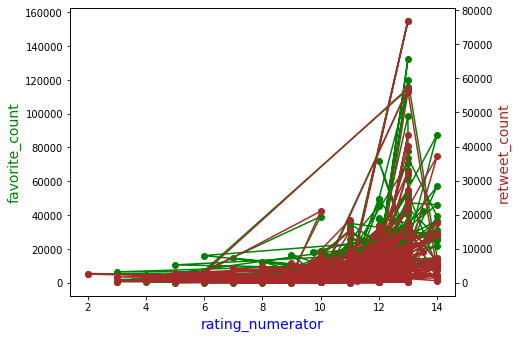

In [123]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
fig.subplots_adjust(bottom=-0.5,top=0.5, left = 0.01)
ax.plot(df_dogs.rating_numerator, df_dogs.favorite_count,color="green", marker="o")
# set x-axis label
ax.set_xlabel("rating_numerator",color="blue",fontsize=14)
# set y-axis label
ax.set_ylabel("favorite_count",color="green",fontsize=14)
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(df_dogs.rating_numerator, df_dogs["retweet_count"],color="brown",marker="o" )
ax2.set_ylabel("retweet_count",color="brown",fontsize=14)
plt.show();

From the plot above, we observe that the data concentration in terms of rating_numerator is centred aroung points 10 and 14. We observe also some huge values of retweet_count and favorite_count.

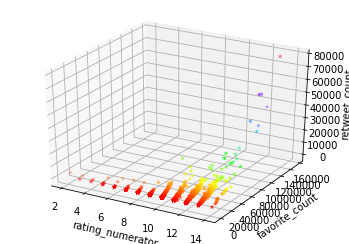

In [124]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
fig.subplots_adjust(bottom=-0.6,top=0.2)

my_cmap = plt.get_cmap('hsv') 

ax.scatter(df_dogs['rating_numerator'],df_dogs['favorite_count'],df_dogs['retweet_count'], c = (df_dogs['rating_numerator'] + df_dogs['favorite_count'] + df_dogs['retweet_count']),  
                    cmap = my_cmap, marker='*', linewidth=0.1)
ax.set_xlabel('rating_numerator')
ax.set_ylabel('favorite_count')
ax.set_zlabel('retweet_count')
plt.axvline(11, c='blue')
plt.show()


So we can see how concentration of the data points. Now let us explore the statisitical information in the data.

In [125]:
df_dogs.describe()

favorite_count  retweet_count  rating_numerator  rating_denominator  \
count     1442.000000    1442.000000       1442.000000              1442.0   
mean      8586.171290    2453.706657         10.909001                10.0   
std      12491.780205    4462.146061          1.686583                 0.0   
min         70.000000      11.000000          2.000000                10.0   
25%       1953.000000     566.250000         10.000000                10.0   
50%       4073.500000    1244.500000         11.000000                10.0   
75%      10690.500000    2828.500000         12.000000                10.0   
max     154886.000000   76957.000000         14.000000                10.0   

           img_num  predicted_confid1  predicted_confid2  predicted_confid3  \
count  1442.000000        1442.000000        1442.000000       1.442000e+03   
mean      1.212899           0.613581           0.141613       6.177018e-02   
std       0.574523           0.260359           0.102738       5.256475e-02   
min       1.000000           0.044333           0.000023       2.160900e-07   
25%       1.000000           0.390003           0.056830       1.523180e-02   
50%       1.000000           0.614025           0.128037       4.995100e-02   
75%       1.000000           0.849795           0.204153       9.554710e-02   
max       4.000000           0.999956           0.467678       2.710420e-01   

       dog_class  
count      226.0  
mean         1.0  
std          0.0  
min          1.0  
25%          1.0  
50%          1.0  
75%          1.0  
max          1.0

So we have 1442 dataset left. The statistic informs us that that 50% of our selected dataset have probablity of 0.61% of not being selected by using our first level of condfidence. Equally it is indicating that 50% of the dogs in sample have rating_numerators lower than 11 points.

When we consider the standard deviation, we see that rating_numerator has a much more smaller standard deviation (1.6) as compared with favorite_count and retweet_count. This might suggest that the data points are on average not so far from its mean (sample/poplation mean). On the other hand, we see that standard deviation of both favoriate_count and retweet_count are 12400 and 4466 respectively. These are huge values that might indicate there are outliers that may be driving standard deviation to be so large.  

Let us draw the mean values of favourite_count (green line) and that of rating_numerator (blue line) in another scatter plot to have a better visualisation of situtation being presented by our statistical exploration.

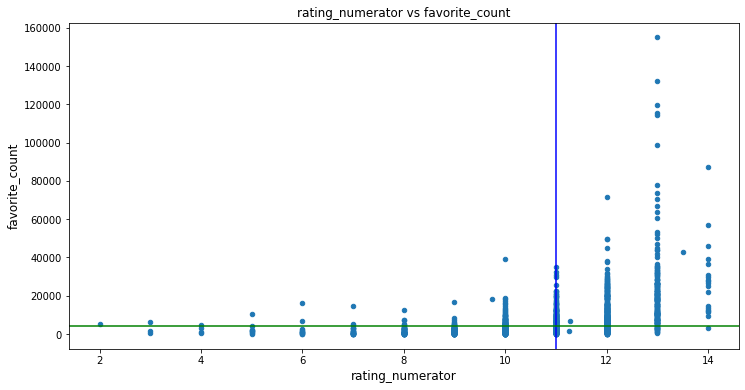

In [126]:
df_dogs.plot(x=['rating_numerator'],y=['favorite_count'],figsize=(12,6), title='rating_numerator vs favorite_count', marker='o', kind='scatter');

plt.ylabel('favorite_count', fontsize=12)
plt.xlabel('rating_numerator', fontsize=12);
#plt.axvline(10, c='green')
plt.axvline(11, c='blue')
plt.axhline(4077, c='green');

The statistic is telling us that all rating_numerator values behind the blue line might not be considered when we us the rating_numerator as an orientation for selection and those behind the green line, when we use the favorite_count as an orientation, might not be selected. 

Let us explore in much more detail the relationship between theses variables. To this end, we will use the seaborn pairplot to plot their pairwise relationships.

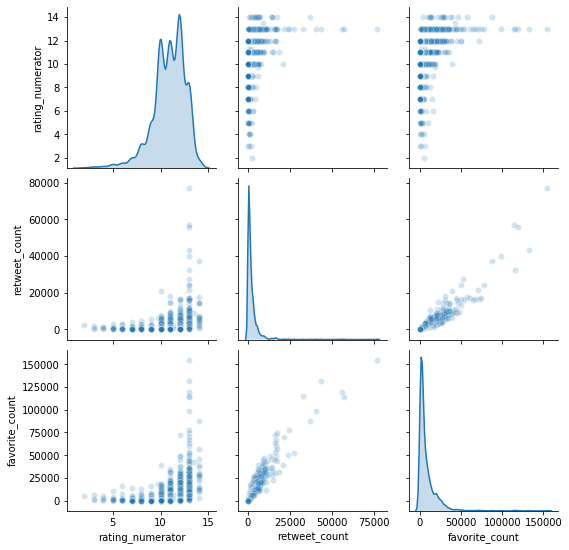

In [127]:
sns.pairplot(df_dogs, 
             vars = ['rating_numerator', 'retweet_count', 'favorite_count'], 
             diag_kind = 'kde', plot_kws = {'alpha': 0.2});

Along the diagonal, we have the displayed distribution of our three variables, with both favorite_count and retweet_count taking almost same form of distributon. The concentration of rating_numerator values are much dense between 10 and 14 points. Taking a closer look at rating_numerator, we see that it is left-skewed distribution.  So we will expect the mean numerator_rating to be less than the median. However, correlation between the rating numerator and it self follows a distribution that somehow looks like a bell-shape distribution. The distribution of both favorite_count/retweet_count follow a right-skewed distribution, with the result their means would be greater than their median. 

On the other hand, interms of the pairwise relationship, correlation between favorite_count and retweet_count is strongly positive, with the data concentration at the lower tail end. 


Let us consider the analysis form another perspective and express the correlation between favorite_count and retweet_count in terms of rating_numerator express as a colour. 

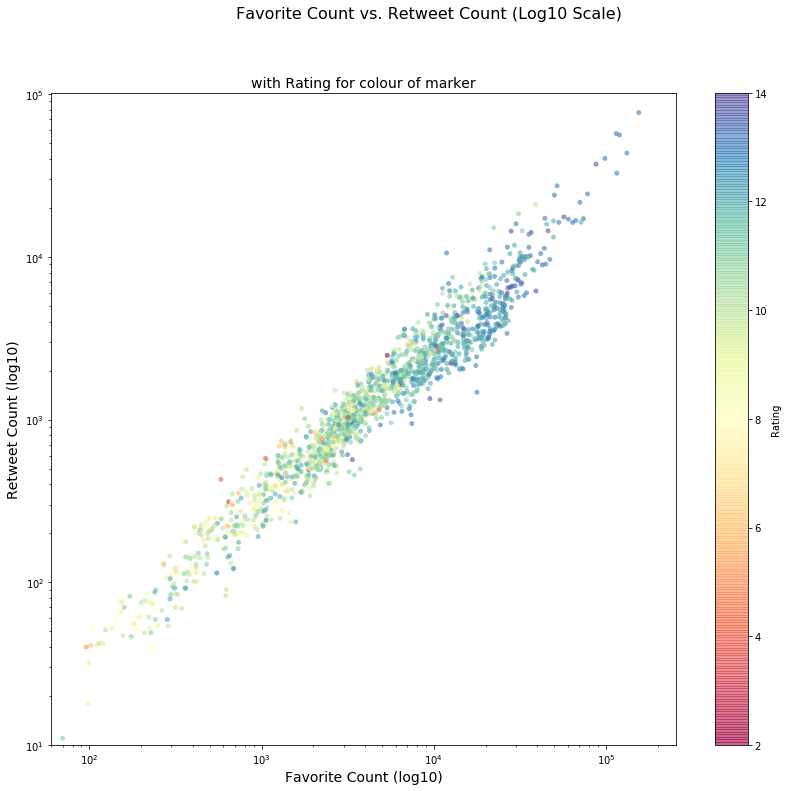

In [128]:
from matplotlib import cm

cmap = cm.get_cmap('Spectral') # Colour map (there are many others)
plt.figure(figsize = (14, 12))

plt.xscale('log')
plt.yscale('log')
plt.xlim(df_dogs['favorite_count'].min() - 10, df_dogs['favorite_count'].max() + 100000)
plt.ylim(10, df_dogs['retweet_count'].max() + 25000)
colours = df_dogs['rating_numerator']
markers = 25

plt.scatter(df_dogs['favorite_count'], df_dogs['retweet_count'], 
            c = colours, s = markers, cmap = cmap, edgecolor = 'None', alpha = 0.6)

# title and labels
plt.suptitle('Favorite Count vs. Retweet Count (Log10 Scale)', fontsize = 16)
plt.title('with Rating for colour of marker', fontsize = 14)
plt.xlabel('Favorite Count (log10)', fontsize = 14)
plt.ylabel('Retweet Count (log10)', fontsize = 14)

# colour bar
cbar = plt.colorbar()
cbar.set_label('Rating')

plt.show();

From the above plot we see an overall picture of a strong positive correlation between retweet_count and favorite_count. It does make sense though, given that fact that a tweet (favourite it) is more likely to to attract a retweet to it as well. This confirms the result form above. The tightly packed points follow a distinct linear trend with a positive slope, so as favorite count increases so does the retweet count. Also evident, tweets with high favorite count and high retweet count also have higher ratings, as shown by the concentration of blue points.

#### In conclusion:

- strong correlation between favorite_count and retweet_count.
- moderate correlation between rating_numerator and favorite_count/retweet_count
- less dispersion in standard deviation of rating_numerator
- large dispersion in standard deviaton of favorite/retweet_count
- evidence of high favorite_count/retweet_count might be and indicator for high               rating_numerator (The reverse may also hold as well)

### 2. How is the dog stage distributed. How do aggregration and mean values of rating_numerator, favorite_count and retweet_count show the patterns of the dog stages distribution? How is resulted dog stage ranked?

Now as a recap, we have all in all 1442 dogs dataset (df_dogs) in our dataset for further analysis. Let us plot a bar graph to show the various classification of dogs. For this we will filter our dataset along dog stage. We will term it the dog class.

In [129]:
df_dogs_class = df_dogs[df_dogs['dog_class'] == 1]

#### Henceforth df_dogs_class

In [130]:
df_dogs_class.shape[0]

226

As we see our new dataset (df_dogs_class) has 226 elements, with its graphical representation displayed below.

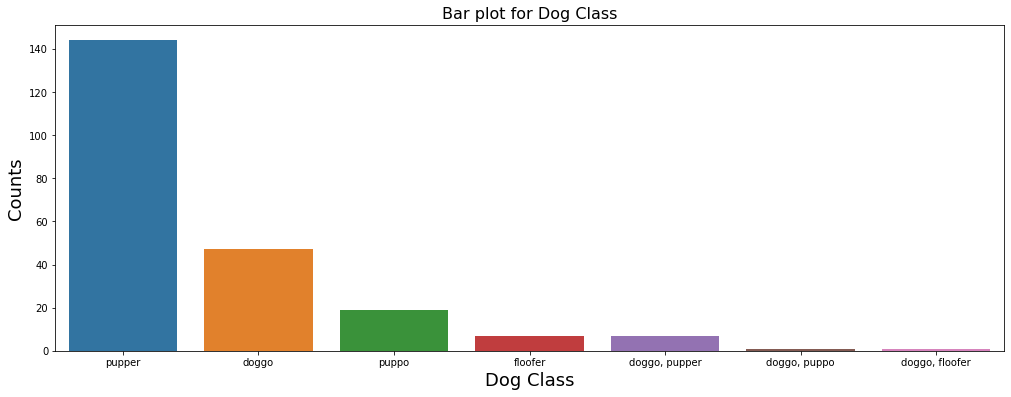

In [131]:
plt.figure(figsize = (17,6))
sns.countplot(df_dogs_class['dog_stage'],order = df_dogs_class['dog_stage'].value_counts().index);
plt.xlabel('Dog Class', fontsize = 18);
plt.ylabel('Counts', fontsize = 18);
plt.title("Bar plot for Dog Class", fontsize = 16);


Here we see class Pupper has the most number of dogs while doggo,floofer and doggo,puppo have the least members. 

Let us now get the percentage distribution the dog class via a pie chart.

In [132]:
# Create a variable and store dog_stage value counts
dog_count = df_dogs_class.groupby('dog_stage').dog_stage.count()
dog_count

dog_stage
doggo              47
doggo, floofer      1
doggo, pupper       7
doggo, puppo        1
floofer             7
pupper            144
puppo              19
Name: dog_stage, dtype: int64

In [133]:
# Create a variable and store the average rating numerator for each dog stage
avg_numerator_rating = df_dogs_class.groupby('dog_stage').rating_numerator.mean()
avg_numerator_rating

dog_stage
doggo             12.000000
doggo, floofer    11.000000
doggo, pupper     11.142857
doggo, puppo      13.000000
floofer           12.000000
pupper            10.953264
puppo             12.000000
Name: rating_numerator, dtype: float64

In [134]:
# Create a function for calculating percentages and labelling different sections of a pie chart
def func(pct, dog_count):
    absolute = int(pct/100.*np.sum(dog_count))
    return "{:.2f}%\n({:d})".format(pct, absolute)

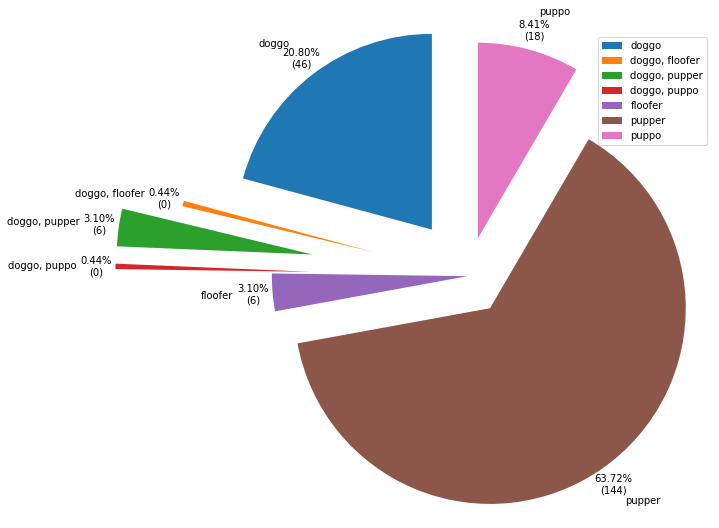

In [135]:
# Plot a pie chart with legend for showing percentage of dogs belonging to different dog stages
explodeTuple = (0.3, 0.5, 0.8, 0.8, 0.0,0.2, 0.2)
plt.figure(figsize = (12, 9))
plt.pie(dog_count, labels = avg_numerator_rating.index.values,explode=explodeTuple,  autopct = lambda pct: func(pct, dog_count),startangle=90, pctdistance=1.1, labeldistance=1.2)
plt.legend();


So we see that the dog_class pupper has 63.72%, and followed by doggo with 20.80%. "doggo,puppo" and "doggo,floofer" have least percentage taking values of 0.44% each.

#### Analysis using mean values of rating_numerator, favorite_count and retweet_count

As the heading above has indicated, we will make a graphical inspection of our dog_class by using a two dimensional plot as indicated below. 

First we create the average dog_class variables.

In [136]:
# create a variable and store the average favorite_count for each dog stage
avg_dog_stage_favorite_count = df_dogs_class.groupby('dog_stage').favorite_count.mean().sort_values(ascending=False)

In [137]:
# create a variable and store the average retweet_count for each dog stage
avg_dog_stage_retweet_count = df_dogs_class.groupby('dog_stage')['retweet_count'].mean().sort_values(ascending=False)

In [138]:
 # create a variable and store the average rating_numerator for each dog stage
avg_dog_stage_rating_numerator = df_dogs_class.groupby('dog_stage')['rating_numerator'].mean().sort_values(ascending=False)

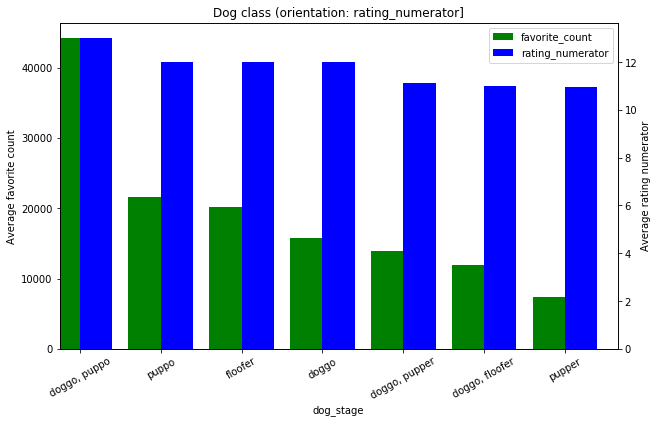

In [139]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

avg_dog_stage_favorite_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog class (orientation: rating_numerator]')
avg_dog_stage_rating_numerator.plot(figsize = (10,6), kind='bar', color='blue', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('Average favorite count')
ax2.set_ylabel('Average rating numerator')
ax1.set_xticklabels(avg_dog_stage_rating_numerator.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

In the bar graph (two dimensional plot) we see dog_class (dog_stage) displayed using average favorite_count (y-axis-left) and average rating_numerator (y-axis-right). On the x-axis we have the dog stage variable (**conditioned**). For a better graph interpretation, it is very important to understand, how the graphs sorted. To this end, we provide a solution to it, by using the term **orientation**. **orientation** indicates the variable by which the graph is sorted. So from the above graph, we are orienting on the rating_numerator. The graph is telling us that conditioned on our dog_stage (**conditioned**) and using the mean values of both the numerator_rating and average favorite_count and orienting on the rating_numerator, the dog_stage "doggo,puppo" had the highest rating, followed by the dog_stage puppo. The class that had the lowest rating is pupper stage.

So we will be using this two defined words (**conditioned** and **orientation**) in the rest of our exploration

Next we have **conditioned**: dog_stage and **orientation**: favorite_count

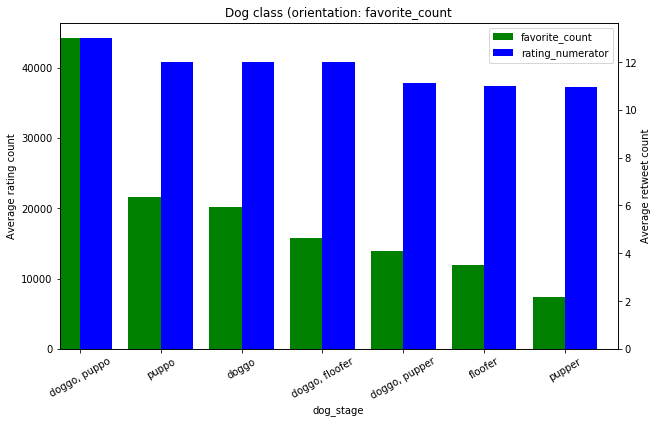

In [140]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

avg_dog_stage_favorite_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog class (orientation: favorite_count')
avg_dog_stage_rating_numerator.plot(figsize = (10,6), kind='bar', color='blue', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('Average rating count')
ax2.set_ylabel('Average retweet count')
ax1.set_xticklabels(avg_dog_stage_favorite_count.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

- we have same the result as before (**orientation**: favorite_count)

Now it is time to explore favorite_count and retweet_count and as **orientation**: favorite_count

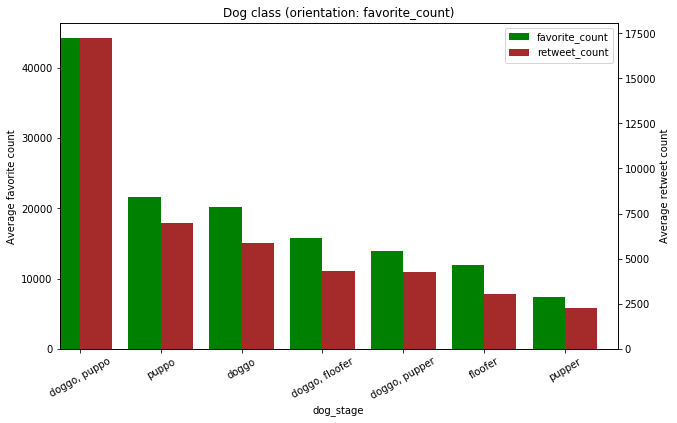

In [141]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

avg_dog_stage_favorite_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog class (orientation: favorite_count)')
avg_dog_stage_retweet_count.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('Average favorite count')
ax2.set_ylabel('Average retweet count')
ax1.set_xticklabels(avg_dog_stage_favorite_count.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

- Here again, we have same result as before (**orientation**: favorite_count, rating_numerator)


- Note: we are using the average values

Let us now use retweet_count and rating_numerator and  **orientation**: rating_numerator

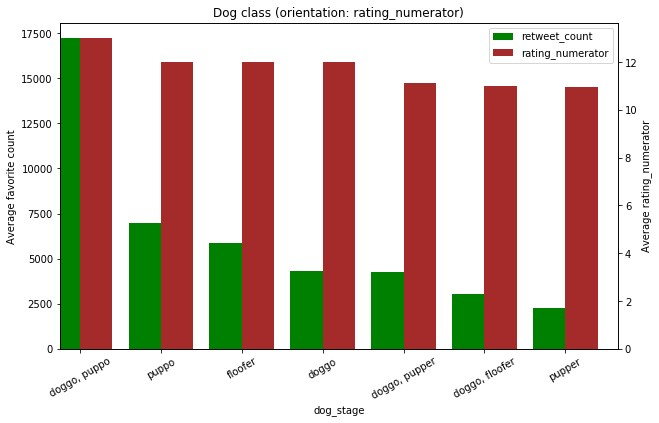

In [142]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

avg_dog_stage_retweet_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog class (orientation: rating_numerator)')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
avg_dog_stage_rating_numerator.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('Average favorite count')
ax2.set_ylabel('Average rating_numerator')
ax1.set_xticklabels(avg_dog_stage_rating_numerator.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

The result is not different from the ones we have had till. Obtained results form cross section of our **orientation** turn to favour the dog_stage "doggo,puppo" 

### In conclusion:

- using dog_state (**conditioned**) and the average values of rating_numerator, favorite_count and retweet_count by orienting on rating_numerator, favorite_count and retweet_count als (**orientation**)

- results are the same. Result turn to favour dog_stage "doggo,puppo" and pupper dog_stage is presented to be the last on the ranking.

#### 2.1 Next focus our exploration on the top 6 dog_breed selected in by our algorithm.

In [143]:
sum_favorite_count = df_dogs_class.groupby('predicted_dogbreed1')['favorite_count'].sum().sort_values(ascending=False).head(6)

In [144]:
sum_retweet_count = df_dogs_class.groupby('predicted_dogbreed1')['retweet_count'].sum().sort_values(ascending=False).head(6)

In [145]:
sum_rating_numerator = df_dogs_class.groupby('predicted_dogbreed1')['rating_numerator'].sum().sort_values(ascending=False).head(6)

Let us now use favorite_count and retweet_count and **orientation**: favorite_count

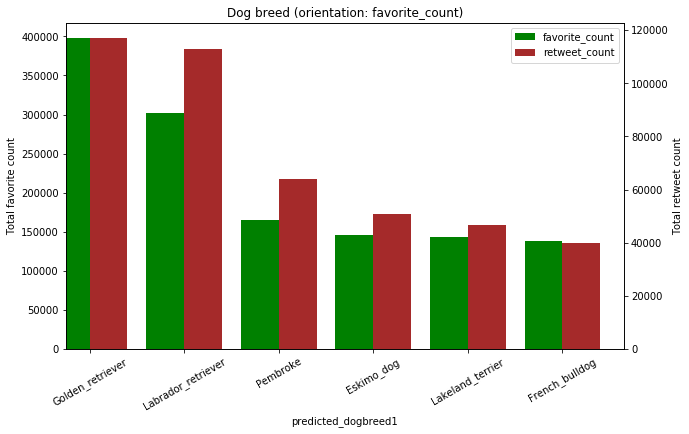

In [146]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sum_favorite_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog breed (orientation: favorite_count)')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
sum_retweet_count.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('Total favorite count')
ax2.set_ylabel('Total retweet count')
ax1.set_xticklabels(sum_favorite_count.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

We see that Golden_retriever has the highest value and then followed by Labrador_retriever, Pembroke, Eskimo_dog, Lakeland_terrier and French_bulldog.

Let us see what we will get by setting the **orientation** to retweet_count

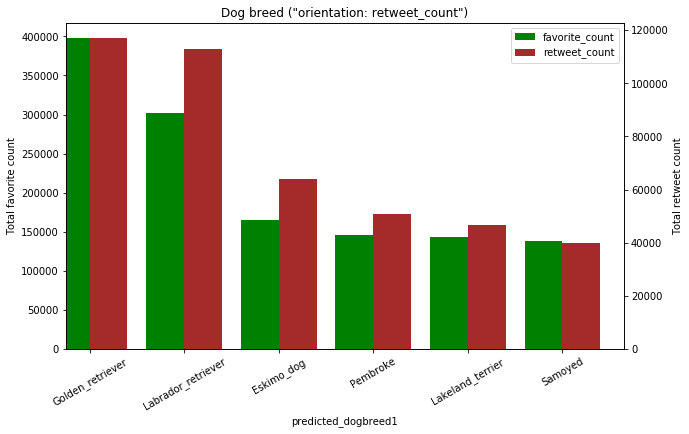

In [147]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sum_favorite_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog breed ("orientation: retweet_count")')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
sum_retweet_count.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('Total favorite count')
ax2.set_ylabel('Total retweet count')
ax1.set_xticklabels(sum_retweet_count.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

Golden_retriever and Labrador_retriever maintained their positions as before. Eskimo_dog and Pembroke have changed positions. Lakeland_terrier remains at the same position and French_bulldog has been sent out and in its place Samoyed brought in.

Let us now use favorite_count and rating_numerator_count and **orientation**: favorite_count

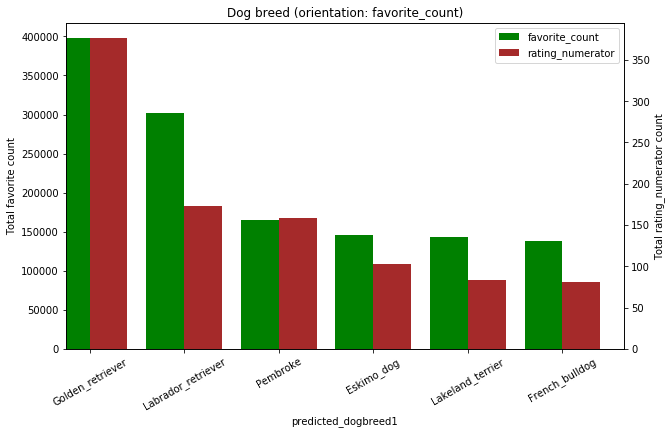

In [148]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sum_favorite_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog breed (orientation: favorite_count)')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
sum_rating_numerator.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('Total favorite count')
ax2.set_ylabel('Total rating_numerator count')
ax1.set_xticklabels(sum_favorite_count.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

So we obtain the same result as using favorite_count, retweet_count with orientation favourite_count

Let us now use favorite_count and rating_numerator_count and **orientation**: rating_numerator

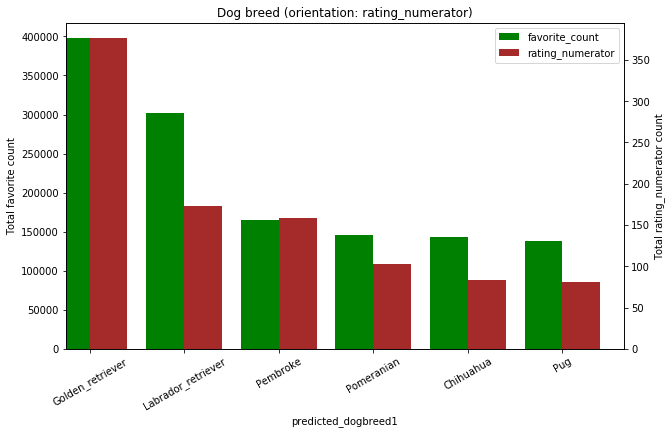

In [149]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sum_favorite_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog breed (orientation: rating_numerator)')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
sum_rating_numerator.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('Total favorite count')
ax2.set_ylabel('Total rating_numerator count')
ax1.set_xticklabels(sum_rating_numerator.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

Here again, Golden_retriever and Labrador_retriever have maintained their positions.  Pembroke has been brought to third position and completely new dog classes like Pomeranian, Chihuahua und Pug have been brought in.

Let us now use retweet_count and rating_numerator_count and **orientation**: retweet_count

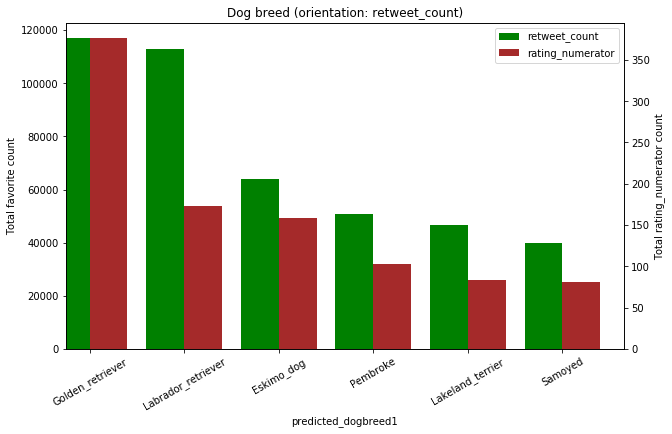

In [150]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sum_retweet_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog breed (orientation: retweet_count)')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
sum_rating_numerator.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('Total favorite count')
ax2.set_ylabel('Total rating_numerator count')
ax1.set_xticklabels(sum_retweet_count.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

So we obtain the same result as using retweet_count, favorite_count with orientation retweet_count

Finally let us use retweet_count, rating_numerator with **orientation** rating_numerator

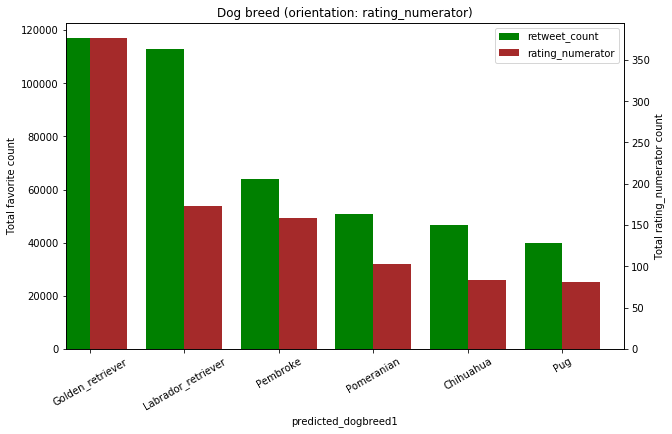

In [151]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

sum_retweet_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog breed (orientation: rating_numerator)')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
sum_rating_numerator.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('Total favorite count')
ax2.set_ylabel('Total rating_numerator count')
ax1.set_xticklabels(sum_rating_numerator.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

We observe that the resultc nsitent with using rating_numerator, favorite_count with orientation rating_numerator.

### In conclusion:

- using aggregation of our rating_numerator, favorite_count and retweet_count condition on predicted_doggreed1 and with **orientation** on rating_numerator, favorite_count and retweet_count we have:


   - Golden_retriever and Labrador_retriever selected across the various **orientation**s and the maintained they same positions (first and second) respectively through out.
   
   
   - there was consistency in the outcome with favour_count or retweet_count with  rating_numerator and favour_count or retweet_count being used as **orientation**.
   
   
   - using rating_numerator against favorite_count/retweet_count with **orientation** rating_numerator, obtained results remain exactly the same.
   
   
   - the result was not exactly the same when favorite_count/retweet_count or retweet_count/favorite_count and **orientation** favorite_count/retweet_count. For example using retweet_count as orientation, Eskimo_dog and Pembroke changed positions and French_bulldog was sent out and in it's place Samoyed brought in, as against what favorite_count has selected.
   
   
   - rating_numerator orientation brought in three completely new dog_breeds namely              Pomeranian, Chihuahua und Pug

Next we will use mean values of favorite_count, retweet_count, rating_numerator

#### 2.2 Mean values favorite_count, retweet_count, rating_numerator for the top 6 best selection breed

Next we construct our variables for the selection.

In [152]:
mean_favorite_count = df_dogs_class.groupby('predicted_dogbreed1')['favorite_count'].mean().sort_values(ascending=False).head(6)

In [153]:
mean_retweet_count = df_dogs_class.groupby('predicted_dogbreed1')['retweet_count'].mean().sort_values(ascending=False).head(6)

In [154]:
mean_rating_numerator = df_dogs_class.groupby('predicted_dogbreed1')['rating_numerator'].mean().sort_values(ascending=False).head(6)

Let us now use favorite_count and retweet_count and set orientation: favorite_count

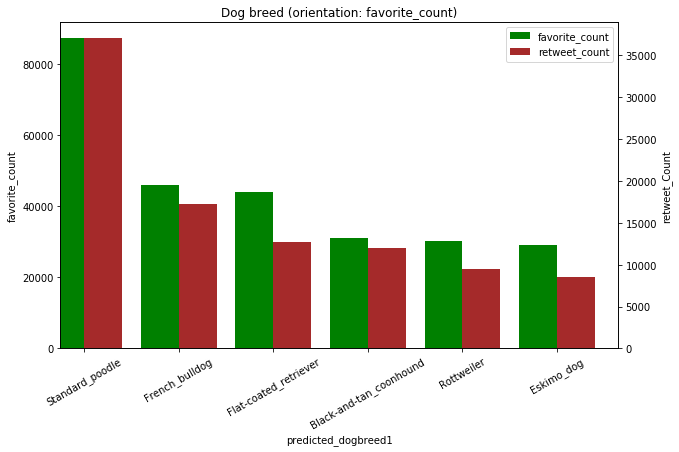

In [155]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

mean_favorite_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog breed (orientation: favorite_count)')
mean_retweet_count.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('favorite_count')
ax2.set_ylabel('retweet_Count')
ax1.set_xticklabels(mean_favorite_count.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();


We see that the selection is quite different to what we obtained, when we just use the aggreation method. Standard_poodle has taken the first postion followed by French_bulldog, Flat-coated_retriever, Black-and-tan_coonhound, Rottweiler and Eskimo_dog respectivly. Apart from the French_bulldog and Eskimo_dog that were selected using aggegation in the last chapter, the rest are completely new.

Let us explore further by using retweet_count as orientation

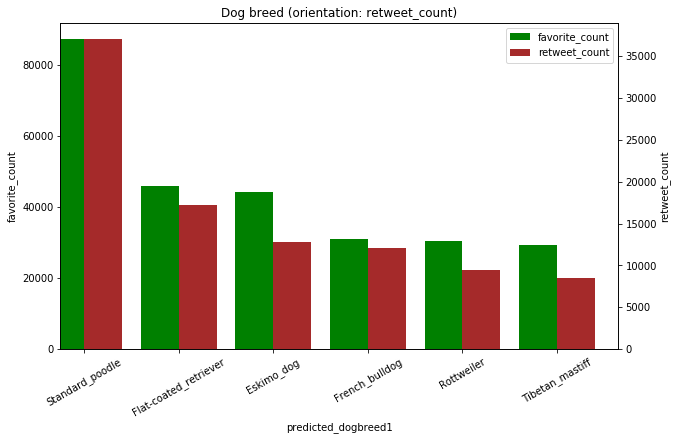

In [156]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

mean_favorite_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog breed (orientation: retweet_count)')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
mean_retweet_count.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('favorite_count')
ax2.set_ylabel('retweet_count')
ax1.set_xticklabels(mean_retweet_count.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();


Here we see that Standard_poodle has maintained its position, Flat_coated_retriever is pushed to the second position, Eskomo_dog given the third position and French_bulldog to the fourth, Rottweiler maintained its position and Tibetan_mastiff brought in and Black-and-tan_coonhound sent out.


Let us determine further by using favorite_numerator and rating_numerator  and the orientation in turns

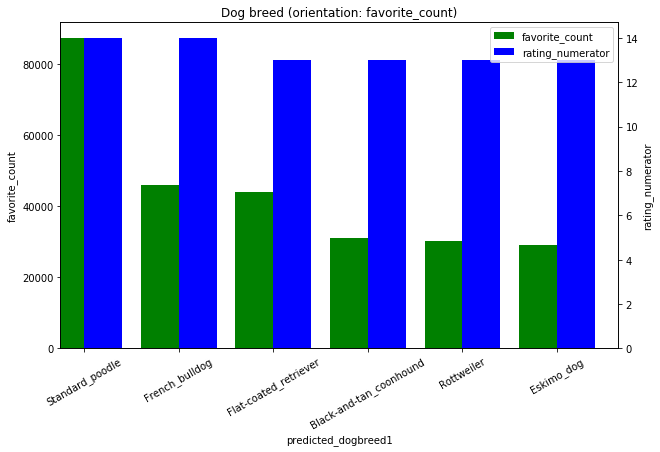

In [157]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

mean_favorite_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog breed (orientation: favorite_count)')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
mean_rating_numerator.plot(figsize = (10,6), kind='bar', color='blue', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('favorite_count')
ax2.set_ylabel('rating_numerator')
ax1.set_xticklabels(mean_favorite_count.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();


The result is the same as using favorite_count, retweet_count with **orientation** favourite_count. 

So we now us rating_numerator as **orientation**

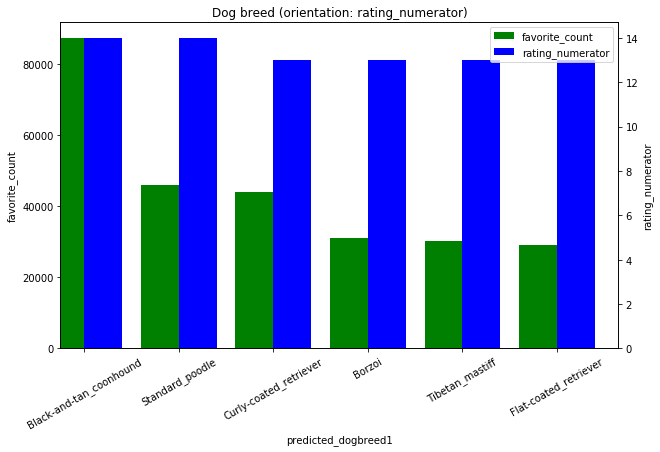

In [158]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

mean_favorite_count.plot(figsize = (10,6), kind='bar', color='green', ax=ax1, width=0.4, position=1, 
             title='Dog breed (orientation: rating_numerator)')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
mean_rating_numerator.plot(figsize = (10,6), kind='bar', color='blue', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('favorite_count')
ax2.set_ylabel('rating_numerator')
ax1.set_xticklabels(mean_rating_numerator.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

Suprisingly Black-and-tan_coonhound has taken the first position and Standard_poodle pushed to the second position, with Curly-coated_retriever, Bazoi, Tibetan_mastiff and Flat-coated_retriver following respectively.

Let us now use retweet_count/favorite_count with retweet_count as **orientation**

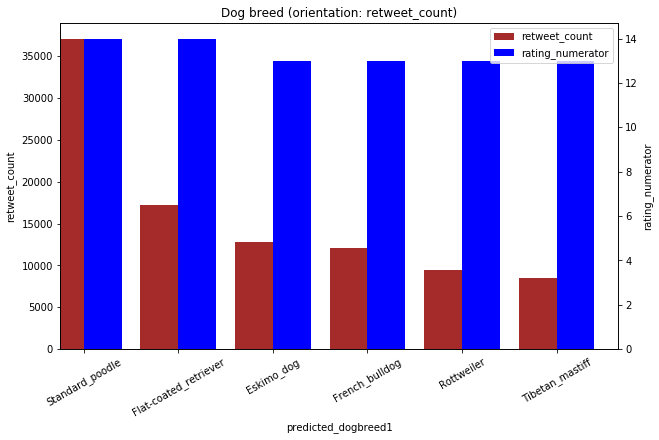

In [159]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

mean_retweet_count.plot(figsize = (10,6), kind='bar', color='brown', ax=ax1, width=0.4, position=1, 
             title='Dog breed (orientation: retweet_count)')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
mean_rating_numerator.plot(figsize = (10,6), kind='bar', color='blue', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('retweet_count')
ax2.set_ylabel('rating_numerator')
ax1.set_xticklabels(mean_retweet_count.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

The result is the same as before as when using retweet_count/favorite_count,by seting **orientation** retweet_count.

Finally let us ascertain how the selection would be retweet_count and rating_numerator and set rating_numerator **orientation**

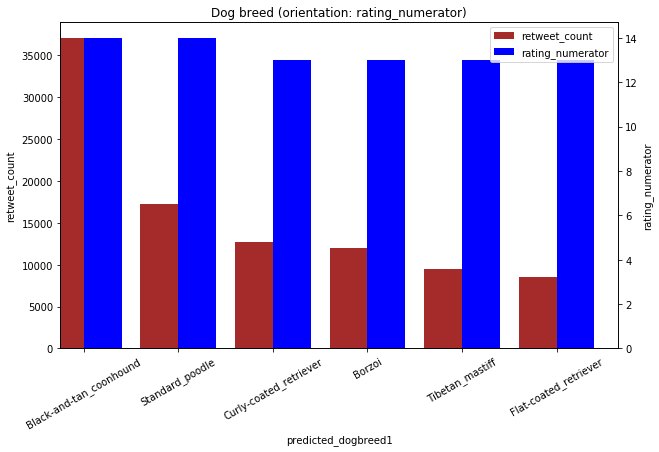

In [160]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

mean_retweet_count.plot(figsize = (10,6), kind='bar', color='brown', ax=ax1, width=0.4, position=1, 
             title='Dog breed (orientation: rating_numerator)')
#dog_favorite.plot(figsize = (10,6), kind='bar', color='brown', ax=ax2, width=0.4, position=0)
mean_rating_numerator.plot(figsize = (10,6), kind='bar', color='blue', ax=ax2, width=0.4, position=0)
ax1.set_ylabel('retweet_count')
ax2.set_ylabel('rating_numerator')
ax1.set_xticklabels(mean_rating_numerator.index, rotation=30)

h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()

plt.legend(h1+h2, l1+l2, loc=1)
#save pic
plt.savefig('popular_dogs.png', dpi=100)

plt.show();

The result is the same as using rating_numerator/favorite_count and seting **orientation** rating_numerator.

### In conclusion:

- using mean values of our rating_numerator, favorite_count and retweet_count condition on predicted_doggreed1 and with orientation on rating_numerator, favorite_count and retweet_count we have:
  

 - Standard_poodle was the most popular dog_breed via cross section of various orientation. It maintain the first position in all, but just two of the **orientation**s, where it captured the second places.
 
- Flat-coated_retriver also appeared in all the selection process.


- there was consistency in the outcome with favour_count/rating_numerator with **orientation** favour_count/rating_numerator


- retweet_count/rating_numerator with **orientation** retweet_count/rating_numerator also produced the same result.



As a recap, after method of aggregation, we selected as top dog breed Golden_retriever and Labrador_retriever. We are now going display the 3 top dogs in this groups by using our orientation approach. 

### Selection 1: predicted_dogbreed1=="Golden_retriever"

#### favorite_count as orientation

In [161]:
# create a table and display information on first 3 dogs
Golden_retriever_breed = df_dogs.query('predicted_dogbreed1=="Golden_retriever"')

In [162]:
Golden_retriever_breed.sort_values(by = 'favorite_count',ascending = False,inplace = True)

In [163]:
#display information on first five dogs
Golden_retriever_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator  \
111            78072          24336              13.0   
606            50182          23947              13.0   
1089           49528          16592              12.0   

                       jpg_url  
111   https://pbs.twimg.com...  
606   https://pbs.twimg.com...  
1089  https://pbs.twimg.com...

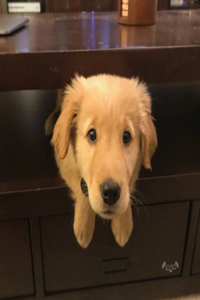

In [164]:
url = Golden_retriever_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

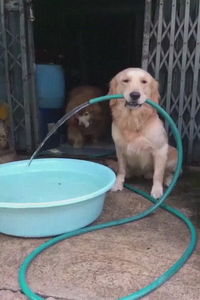

In [165]:
url = Golden_retriever_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

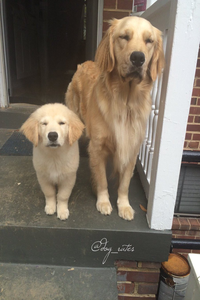

In [166]:
url = Golden_retriever_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

#### Retweet as **orientation**

In [167]:
Golden_retriever_breed.sort_values(by = 'retweet_count',ascending = False,inplace = True)

In [168]:
#display information on first 3 dogs
Golden_retriever_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator  \
111            78072          24336              13.0   
606            50182          23947              13.0   
1089           49528          16592              12.0   

                       jpg_url  
111   https://pbs.twimg.com...  
606   https://pbs.twimg.com...  
1089  https://pbs.twimg.com...

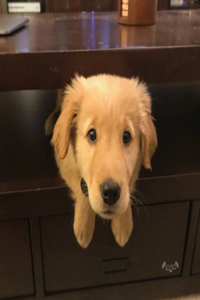

In [169]:
url = Golden_retriever_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200,300), Image.ANTIALIAS)

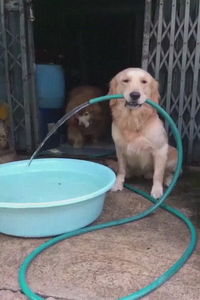

In [170]:
url = Golden_retriever_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200,300), Image.ANTIALIAS)

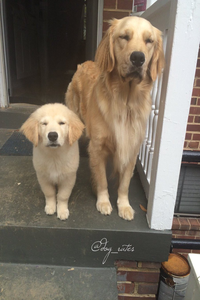

In [171]:
url = Golden_retriever_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200,300), Image.ANTIALIAS)

#### favorite vrs retweet orientation

-  the same dogs were selected in first, second and third positions

#### rating_numerator as orientation

In [172]:
Golden_retriever_breed.sort_values(by = 'rating_numerator', ascending = False,inplace = True)

In [173]:
#display information on first 3 dogs
Golden_retriever_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator                   jpg_url
354            9500           1345              14.0  https://pbs.twimg.com...
516           14764           3673              14.0  https://pbs.twimg.com...
44            42657           8925              13.5  https://pbs.twimg.com...

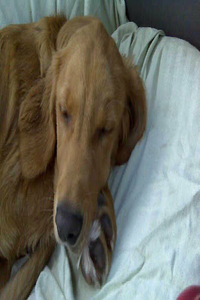

In [174]:
url = Golden_retriever_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

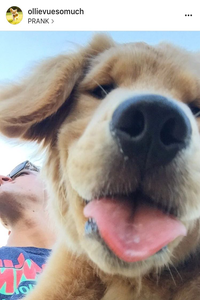

In [175]:
url = Golden_retriever_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

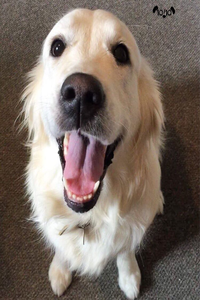

In [176]:
url = Golden_retriever_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

Let us conclude our observation of the selection within breeds and between orientation.

### Conclusion (within-breed-selection and between-orientation-selection)

- same dog breed and same first three dogs selected in the same order within Golden_retriever (favorite_count and retweet_count)

- different dogs selected within the breed (rating_numerator).
   

#### Selection 2: predicted_dogbreed1=="Labrador_retriever" 

In [177]:
# create a table and display information on first 3 dogs
Labrador_retriever_breed = df_dogs_class.query('predicted_dogbreed1=="Labrador_retriever"')

#### favorite_count as **orientation**

In [178]:
Labrador_retriever_breed.sort_values(by = 'favorite_count',ascending = False,inplace = True)

In [179]:
#display information on first 3 dogs
Labrador_retriever_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator  \
1015          154886          76957              13.0   
48             26309           4415              12.0   
97             25500           4939              12.0   

                       jpg_url  
1015  https://pbs.twimg.com...  
48    https://pbs.twimg.com...  
97    https://pbs.twimg.com...

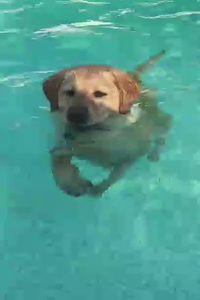

In [180]:
url = Labrador_retriever_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

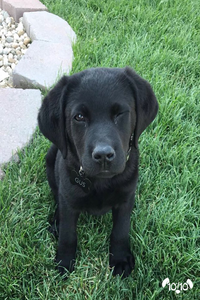

In [181]:
url = Labrador_retriever_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

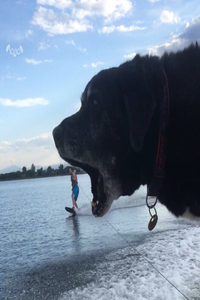

In [182]:
url = Labrador_retriever_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

#### retweet_count as orientation

In [183]:
Labrador_retriever_breed.sort_values(by = 'retweet_count',ascending = False,inplace = True)

In [184]:
#display information on first five dogs
Labrador_retriever_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator  \
1015          154886          76957              13.0   
625            15471           5700              12.0   
97             25500           4939              12.0   

                       jpg_url  
1015  https://pbs.twimg.com...  
625   https://pbs.twimg.com...  
97    https://pbs.twimg.com...

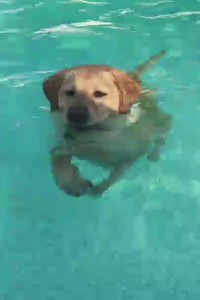

In [185]:
url = Labrador_retriever_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300))

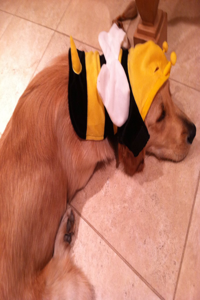

In [186]:
url = Labrador_retriever_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300))

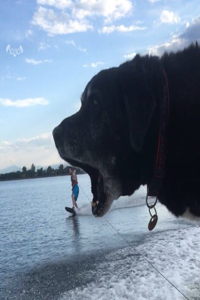

In [187]:
url = Labrador_retriever_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300))

- same dogs in positions 1 and 3, different dogs in position 2

#### rating_numerator as **orientation**

In [188]:
Labrador_retriever_breed.sort_values(by = 'rating_numerator',ascending = False,inplace = True)

In [189]:
#display information on first five dogs
Labrador_retriever_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator  \
1015          154886          76957              13.0   
539            11079           4199              13.0   
375             4895            925              13.0   

                       jpg_url  
1015  https://pbs.twimg.com...  
539   https://pbs.twimg.com...  
375   https://pbs.twimg.com...

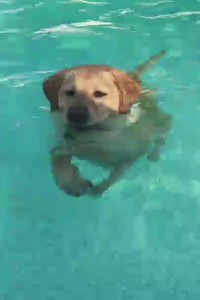

In [190]:
url = Labrador_retriever_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300))

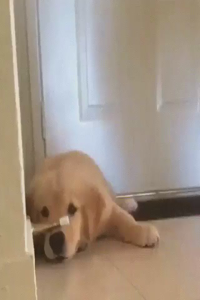

In [191]:
url = Labrador_retriever_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300))

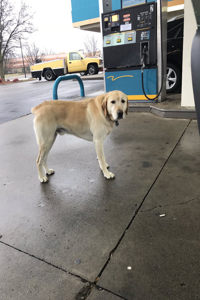

In [192]:
url = Labrador_retriever_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300))

### Conclusion (within-breed-selection and between-orientation-selection)

 - same dog selected in the first position by all orientations (favorite_count, retweet_count and rating_numerator)
 - same dogs selected in positions one and three by favorite_count and retweet_count
 - different dogs selected by rating_numerator in positions 2 and 3


Let us continue by using our second approach (using mean of rating_numerator, favorite_count and retweet_count) for the dog breed selected: Standard_poodle 

#### Selection 1: predicted_dogbreed1=="Standard_poodle" 

In [193]:
# create a table and display information on first 3 dogs
Standard_poodle_breed = df_dogs.query('predicted_dogbreed1=="Standard_poodle"')

#### favorite_count as orientation

In [194]:
Standard_poodle_breed.sort_values(by = 'favorite_count',ascending = False,inplace = True)

In [195]:
#display information on first 3 dogs
Standard_poodle_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator  \
433            87481          37103              14.0   
852             4489           1084              11.0   
1126            4362           1123               9.0   

                       jpg_url  
433   https://pbs.twimg.com...  
852   https://pbs.twimg.com...  
1126  https://pbs.twimg.com...

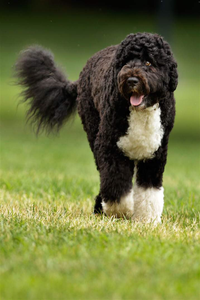

In [196]:
url = Standard_poodle_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

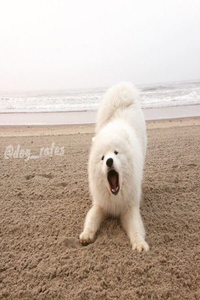

In [197]:
url = Standard_poodle_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

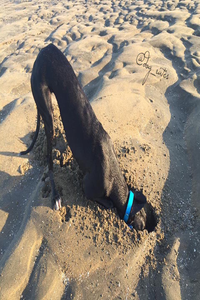

In [198]:
url = Standard_poodle_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

Let us explore by using retweet_count as orientation

#### retweet_count as orientation

In [199]:
Standard_poodle_breed.sort_values(by = 'retweet_count',ascending = False,inplace = True)

In [200]:
#display information on first 2 dogs
Standard_poodle_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator  \
433            87481          37103              14.0   
1126            4362           1123               9.0   
852             4489           1084              11.0   

                       jpg_url  
433   https://pbs.twimg.com...  
1126  https://pbs.twimg.com...  
852   https://pbs.twimg.com...

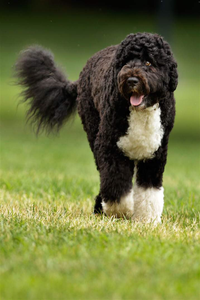

In [201]:
url = Standard_poodle_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

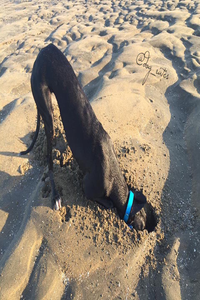

In [202]:
url = Standard_poodle_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

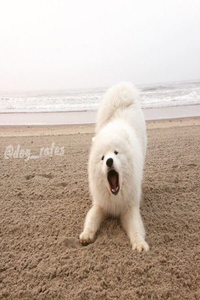

In [203]:
url = Standard_poodle_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

Let use explore by using rating_numerator as orientation

#### rating_numerator as orientation

In [204]:
Standard_poodle_breed.sort_values(by = 'rating_numerator',ascending = False,inplace = True)

In [205]:
#display information on first 2 dogs
Standard_poodle_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator                   jpg_url
433           87481          37103              14.0  https://pbs.twimg.com...
852            4489           1084              11.0  https://pbs.twimg.com...
952            2710            787              10.0  https://pbs.twimg.com...

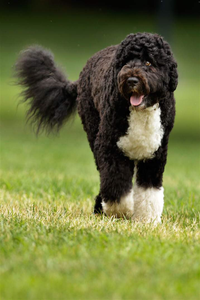

In [206]:
url = Standard_poodle_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

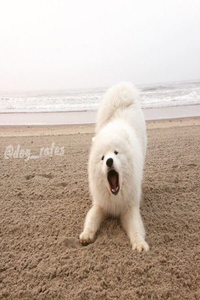

In [207]:
url = Standard_poodle_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

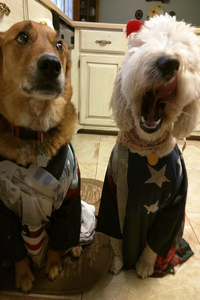

In [208]:
url = Standard_poodle_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

### Conclusion (within-breed-selection and between-orientation-selection)

- same dog selected in the first position by all orientations (favorite_count, retweet_count and rating_numerator)
- same dogs selected in positions two by favorite_count and rating_numerator
- same dogs but positions 2 and 3 are switched by favorite_count and retweet_count




Let use continue to with our second selection. Flat-coated_retriever

#### Selection 2. predicted_dogbreed1=="Flat-coated_retriever" 

In [209]:
# create a table and display information on first five dogs
Flat_Coated_retriever_breed = df_dogs.query('predicted_dogbreed1=="Flat-coated_retriever"')

#### favorite_count as orientation

In [210]:
Flat_Coated_retriever_breed.sort_values(by = 'favorite_count',ascending = False,inplace = True)

In [211]:
#display information on first 2 dogs
Flat_Coated_retriever_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator                   jpg_url
183           44167          17213              13.0  https://pbs.twimg.com...
217           24683           4211              12.0  https://pbs.twimg.com...
92            21252           3628              12.0  https://pbs.twimg.com...

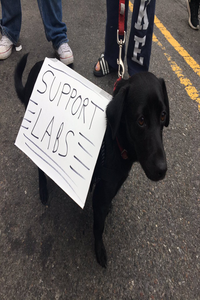

In [212]:
url = Flat_Coated_retriever_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

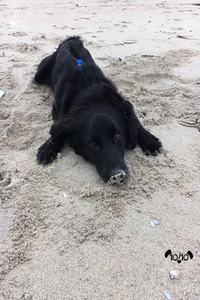

In [213]:
url = Flat_Coated_retriever_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

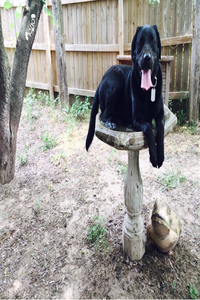

In [214]:
url = Flat_Coated_retriever_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

#### retweet_count as orientation

In [215]:
Flat_Coated_retriever_breed.sort_values(by = 'retweet_count',ascending = False,inplace = True)

In [216]:
#display information on first 3 dogs
Flat_Coated_retriever_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator                   jpg_url
183           44167          17213              13.0  https://pbs.twimg.com...
217           24683           4211              12.0  https://pbs.twimg.com...
92            21252           3628              12.0  https://pbs.twimg.com...

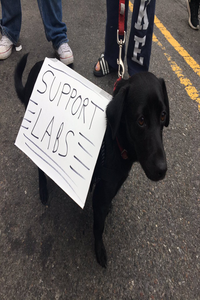

In [217]:
url = Flat_Coated_retriever_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

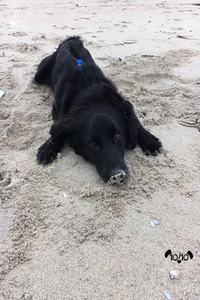

In [218]:
url = Flat_Coated_retriever_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

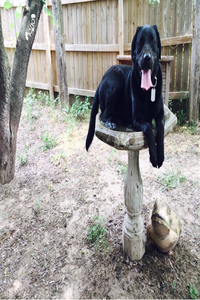

In [219]:
url = Flat_Coated_retriever_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

#### rating_numerator as orientation

In [220]:
Flat_Coated_retriever_breed.sort_values(by = 'rating_numerator',ascending = False,inplace = True)

In [221]:
#display information on first 2 dogs
Flat_Coated_retriever_breed.loc[:,['favorite_count','retweet_count','rating_numerator','jpg_url']][0:3]

favorite_count  retweet_count  rating_numerator                   jpg_url
183           44167          17213              13.0  https://pbs.twimg.com...
217           24683           4211              12.0  https://pbs.twimg.com...
92            21252           3628              12.0  https://pbs.twimg.com...

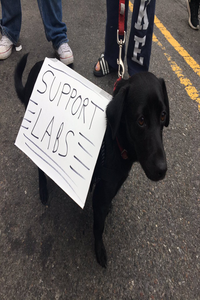

In [222]:
url = Flat_Coated_retriever_breed['jpg_url'].values[0]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

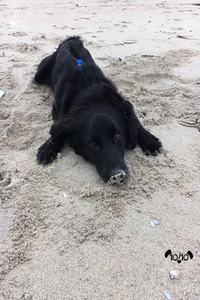

In [223]:
url = Flat_Coated_retriever_breed['jpg_url'].values[1]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

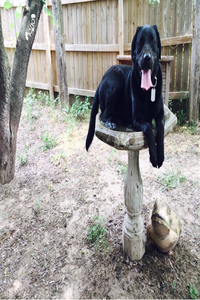

In [224]:
url = Flat_Coated_retriever_breed['jpg_url'].values[2]
response = requests.get(url)
pilImage =Image.open(BytesIO(response.content))
pilImage.resize((200, 300), Image.ANTIALIAS)

### Conclusion (within-breed-selection and between-orientation-selection)

- same dogs selected in the first, second and third positions by all orientations (favorite_count, retweet_count and rating_numerator)
    


### Research Question 5. How did the algorithm perform at a confidence level (> 5) in the selection of the top 6 dog breeds by using the three forms of the sample dataset by using the aggregation method?


Let us test the algorithm's first prediction efficiency for top 6 most frequent breed predictions by using a prediction confidence level (>= 0.5)

#### Algorithm's performance using the dataset for twitter_final_table 

In [225]:
# create a subset of twitter_final_table with the required variables
pred_eff = twitter_final_table[['tweet_id', 'predicted_dogbreed1', 'predicted_confid1', 'predicted_dog1']].copy()

In [226]:
# display the first five lines
pred_eff.head()

tweet_id predicted_dogbreed1  predicted_confid1 predicted_dog1
0  892420643555336193              Orange           0.097049          False
1  892177421306343426           Chihuahua           0.323581           True
2  891815181378084864           Chihuahua           0.716012           True
3  891689557279858688         Paper_towel           0.170278          False
4  891327558926688256              Basset           0.555712           True

In [227]:
# Store the prediction names of the 6 most frequent predictions in a seperate variable
prediction_names = pred_eff.predicted_dogbreed1.value_counts().head(6).index.values
prediction_names

[Golden_retriever, Labrador_retriever, Pembroke, Chihuahua, Pug, Chow]
Categories (378, object): [Acorn_squash, Afghan_hound, African_crocodile, African_grey, ..., Wooden_spoon, Wool, Yorkshire_terrier, Zebra]

Let us loop over the whole dataset and let us store instances where the algorithm's successfuly pedicted with a prediction confidence (predicted_confid1) of (> 0.5) in first its first prediction into a list

In [228]:
# store the instances when algorithm's first prediction has been successful in a list
true_counts = []
for item in prediction_names:
    x = pred_eff[(pred_eff['predicted_dogbreed1'] == item) & (pred_eff['predicted_confid1'] > 0.5) & (pred_eff.predicted_dog1 == True)]['predicted_confid1'].count()
    true_counts.append(x)
true_counts

[114, 60, 70, 46, 43, 26]

In [229]:
# store the value counts of 6 most frequent predictions in a seperate variable
total_predictions = pred_eff.predicted_dogbreed1.value_counts().head(6).values
total_predictions

array([134,  89,  88,  78,  54,  41], dtype=int64)

In [230]:
# create a dataframe for the above 3 new variables
eff_dict = {'prediction_name': prediction_names, 'prediction_total':total_predictions, 'prediction_correct':true_counts}
eff_result = pd.DataFrame(eff_dict, columns=['prediction_name', 'prediction_total', 'prediction_correct'])
eff_result

prediction_name  prediction_total  prediction_correct
0    Golden_retriever               134                 114
1  Labrador_retriever                89                  60
2            Pembroke                88                  70
3           Chihuahua                78                  46
4                 Pug                54                  43
5                Chow                41                  26

The above table displays the algotithm's total predictions on one hand and corrected prediction on the other hand. Let us now determine the efficiency of algorithm predictions

Let us now determine the algorithm's prediction efficiency

In [231]:
# calculate the prediction efficiency in a seperate column
eff_result['prediction_efficiency (in %)'] = (eff_result['prediction_correct'] / eff_result['prediction_total'])*100
eff_result

prediction_name  prediction_total  prediction_correct  \
0    Golden_retriever               134                 114   
1  Labrador_retriever                89                  60   
2            Pembroke                88                  70   
3           Chihuahua                78                  46   
4                 Pug                54                  43   
5                Chow                41                  26   

   prediction_efficiency (in %)  
0                 85.074627      
1                 67.415730      
2                 79.545455      
3                 58.974359      
4                 79.629630      
5                 63.414634

So we see from the above table that the algorithm has proved to be most efficient for Golden Retrievers, when we set the confidence level at (> 0.5). Here prediction efficiency is about 85%. However, its performance is least efficient for Chihuahuas breed, and efficiency of about 59%. 
  

Now we continue with dataset on df_dogs table 

In [232]:
# create a subset of twitter_final_table with the required variables
pred_eff = df_dogs[['tweet_id', 'predicted_dogbreed1', 'predicted_confid1', 'predicted_dog1']].copy()

In [233]:
# display the first five lines
pred_eff.head()

tweet_id       predicted_dogbreed1  predicted_confid1  \
1  892177421306343426                 Chihuahua           0.323581   
2  891815181378084864                 Chihuahua           0.716012   
4  891327558926688256                    Basset           0.555712   
5  891087950875897856  Chesapeake_bay_retriever           0.425595   
6  890971913173991426               Appenzeller           0.341703   

  predicted_dog1  
1           True  
2           True  
4           True  
5           True  
6           True

In [234]:
# Store the value counts of 6 most frequent predictions in a seperate variable
total_predictions = pred_eff.predicted_dogbreed1.value_counts().head(6).values
total_predictions

array([134,  89,  88,  78,  54,  41], dtype=int64)

In [235]:
# Store the prediction names of 6 most frequent predictions in a seperate variable
prediction_names = pred_eff.predicted_dogbreed1.value_counts().head(6).index.values
prediction_names

[Golden_retriever, Labrador_retriever, Pembroke, Chihuahua, Pug, Chow]
Categories (378, object): [Acorn_squash, Afghan_hound, African_crocodile, African_grey, ..., Wooden_spoon, Wool, Yorkshire_terrier, Zebra]

In [236]:
# store the instances when algorithm's first prediction has been successful in a list
true_counts = []
for item in prediction_names:
    x = pred_eff[(pred_eff['predicted_dogbreed1'] == item) & (pred_eff['predicted_confid1'] > 0.5) & (pred_eff.predicted_dog1 == True)]['predicted_confid1'].count()
    true_counts.append(x)
true_counts

[114, 60, 70, 46, 43, 26]

In [237]:
# create a dataframe for the above 3 new variables
eff_dict = {'prediction_name': prediction_names, 'prediction_total':total_predictions, 'prediction_correct':true_counts}
eff_result = pd.DataFrame(eff_dict, columns=['prediction_name', 'prediction_total', 'prediction_correct'])
eff_result

prediction_name  prediction_total  prediction_correct
0    Golden_retriever               134                 114
1  Labrador_retriever                89                  60
2            Pembroke                88                  70
3           Chihuahua                78                  46
4                 Pug                54                  43
5                Chow                41                  26

In [238]:
# calculate the prediction efficiency in a seperate column
eff_result['prediction_efficiency(in %)'] = (eff_result['prediction_correct'] / eff_result['prediction_total'])*100
eff_result

prediction_name  prediction_total  prediction_correct  \
0    Golden_retriever               134                 114   
1  Labrador_retriever                89                  60   
2            Pembroke                88                  70   
3           Chihuahua                78                  46   
4                 Pug                54                  43   
5                Chow                41                  26   

   prediction_efficiency(in %)  
0                 85.074627     
1                 67.415730     
2                 79.545455     
3                 58.974359     
4                 79.629630     
5                 63.414634

#### Finally on the df_dog_class

In [239]:
# create a subset of twitter_final_table with the required variables
pred_eff = df_dogs_class[['tweet_id', 'predicted_dogbreed1', 'predicted_confid1', 'predicted_dog1']].copy()

In [240]:
# display the first five lines
pred_eff.head()

tweet_id predicted_dogbreed1  predicted_confid1 predicted_dog1
9   890240255349198849            Pembroke           0.511319           True
12  889665388333682689            Pembroke           0.966327           True
14  889531135344209921    Golden_retriever           0.953442           True
28  886366144734445568      French_bulldog           0.999201           True
42  884162670584377345     German_shepherd           0.707046           True

In [241]:
# Store the value counts of 10 most frequent predictions in a seperate variable
total_predictions = pred_eff.predicted_dogbreed1.value_counts().head(6).values
total_predictions

array([32, 15, 13,  9,  8,  7], dtype=int64)

In [242]:
# Store the prediction names of 10 most frequent predictions in a seperate variable
prediction_names = pred_eff.predicted_dogbreed1.value_counts().head(6).index.values
prediction_names

[Golden_retriever, Labrador_retriever, Pembroke, Pomeranian, Pug, Chihuahua]
Categories (378, object): [Acorn_squash, Afghan_hound, African_crocodile, African_grey, ..., Wooden_spoon, Wool, Yorkshire_terrier, Zebra]

In [243]:
#store the instances when algorithm's first prediction has been successful in a list
true_counts = []
for item in prediction_names:
    x = pred_eff[(pred_eff['predicted_dogbreed1'] == item) & (pred_eff['predicted_confid1'] > 0.5) & (pred_eff.predicted_dog1 == True)]['predicted_confid1'].count()
    true_counts.append(x)
true_counts

[28, 9, 8, 8, 7, 3]

In [244]:
# create a dataframe for the above 3 new variables
eff_dict = {'prediction_name': prediction_names, 'prediction_total':total_predictions, 'prediction_correct':true_counts}
eff_result = pd.DataFrame(eff_dict, columns=['prediction_name', 'prediction_total', 'prediction_correct'])
eff_result

prediction_name  prediction_total  prediction_correct
0    Golden_retriever                32                  28
1  Labrador_retriever                15                   9
2            Pembroke                13                   8
3          Pomeranian                 9                   8
4                 Pug                 8                   7
5           Chihuahua                 7                   3

In [245]:
# calculate the prediction efficiency in a seperate column
eff_result['prediction_efficiency(in %)'] = (eff_result['prediction_correct'] / eff_result['prediction_total'])*100
eff_result

prediction_name  prediction_total  prediction_correct  \
0    Golden_retriever                32                  28   
1  Labrador_retriever                15                   9   
2            Pembroke                13                   8   
3          Pomeranian                 9                   8   
4                 Pug                 8                   7   
5           Chihuahua                 7                   3   

   prediction_efficiency(in %)  
0                 87.500000     
1                 60.000000     
2                 61.538462     
3                 88.888889     
4                 87.500000     
5                 42.857143

### Conclusion (Algorithm's prediction performance)

- prediction performance for the dog Golden_retriever and Pomeranian generally the best. 
- worst performance was against dog breed Chihuahua

<a id='report wrangling'></a>
## 6. Report Wrangling

The following two reports are standalone documents available:

**wrangle_report_PAUL_DZITSE.ipynb**: this is an internal report briefly describes the data wrangling and data cleaning efforts.

**act_report_PAUL_DZITSE.ipynb**: this is an external report that communicates the insights and visalizations produced from the wrangled and cleaned data.

<a id='resources'></a>
## 7. Resources

 - https://stackoverflow.com/questions/10993612/python-removing-xa0-from-string

 - https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/

 - https://stackoverflow.com/questions/5250744/difference-between-open-and-codecs-open-in-python/22288895#22288895

 - https://github.com/siznax/wptools/wiki/Usage#page-usage

 - https://www.tibco.com/blog/2014/01/23/api-data-exchange-xml-vs-json/

 - https://stackoverflow.com/questions/28056171/how-to-build-and-fill-pandas-dataframe-from-for-loop/28058264#28058264

 - https://www.reddit.com/r/Python/comments/1tqjt4/why_do_you_use_pandas_instead_of_sql/

 - https://chrisalbon.com/

 - https://stackoverflow.com/questions/18837262/convert-python-dict-into-a-dataframe

 - https://www.json.org/json-en.html
 
 - https://cmdlinetips.com/2019/10/how-to-make-a-plot-with-two-different-y-axis-in-python   withmat plotlib/
 
 - https://www.youtube.com/watch?v=hxn2ZzvpZ0I
 
 - https://pythonprogramming.net/matplotlib-3d-scatterplot-tutorial/
 
 - https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/
